# Green Fuzzing: A Saturation-based Stopping Criterion using Vulnerability Prediction

In [1]:
R.version

               _                           
platform       x86_64-apple-darwin22.4.0   
arch           x86_64                      
os             darwin22.4.0                
system         x86_64, darwin22.4.0        
status                                     
major          4                           
minor          3.0                         
year           2023                        
month          04                          
day            21                          
svn rev        84292                       
language       R                           
version.string R version 4.3.0 (2023-04-21)
nickname       Already Tomorrow            

---

**Required R Packages:**

In [2]:
install.packages("pacman")

Installiere Paket nach ‘/usr/local/lib/R/4.3/site-library’
(da ‘lib’ nicht spezifiziert)



In [3]:
library(pacman)

In [ ]:
pacman::p_load(
    caret,
    devtools,
    doParallel,
    dplyr,
    gbm,
    ggcorrplot,
    ggplot2,
    ggtext,
    kernlab,
    Metrics,
    modelr,
    parallel,
    plotROC,
    pROC,
    randomForest,
    RColorBrewer,
    scales,
    stringr,
    tidyr,
    tidyverse
)

---

In [5]:
options(warn = -1)

In [6]:
my_theme <- theme_light(18) +
    theme(legend.margin = ggplot2::margin(b = 0)) +
    theme(
        axis.title.x = element_text(margin = ggplot2::margin(t = 10, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = ggplot2::margin(t = 0, r = 10, b = 0, l = 10))
    )

theme_set(my_theme)

In [7]:
gray_color_tones = c("gray25", "gray50", "gray75")

In [8]:
c_div <- function(a, b) {
    if (b == 0) {
        return(0)
    } else {
        return(a / b)
    }
}

In [9]:
map_values <- function(map) {
    values <- c()
    for (key in ls(map)) {
        values <- append(values, map[[key]])
    }
    return(unique(values))
}

In [10]:
figure_path <- function(name, root_dir = "./figures", img_type = "pdf") {
    return(paste(root_dir, paste(name, img_type, sep = "."), sep = "/"))
}

## ML-based Vulnerability Prediction

---

**Script Options:**

In [11]:
# If set to TRUE, the pre-trained models in the "./models" directory are used for the vulnerability prediction.
# Otherwise, the prediction models will be newly trained (FALSE).
USE_PRETRAINED_MODELS <- TRUE

# If set to TRUE, the (newly trained) vulnerability prediction models will be persisted in the "./models"
# directory, otherwise not (FALSE).
SAVE_MODELS <- FALSE

---

### Dataset

In [12]:
has_flag <- function(lines) {
    return(lines != "")
}

n_has_flag <- function(lines_vec) {
    return(sum(as.numeric(lapply(FUN = has_flag, X = lines_vec))))
}

n_flagged_lines <- function(lines_vec, line_del = ";") {
    lines <- paste(Filter(has_flag, lines_vec), collapse = line_del)
    if (!has_flag(lines)) {
        return(0)
    } else {
        return(length(unique(as.numeric(str_split(lines, line_del, simplify = TRUE)))))
    }
}

In [13]:
function_info <- read.csv("./data/function_info.csv", stringsAsFactors = FALSE)

head(function_info)

,Subject,Function
,<chr>,<chr>
1,libpng,pngerror.c:png_error
2,libpng,pngerror.c:png_default_error
3,libpng,pngerror.c:png_longjmp
4,libpng,pngerror.c:png_safecat
5,libpng,pngerror.c:png_format_number
6,libpng,pngerror.c:png_benign_error


In [14]:
ml_feature_data <- read.csv("./data/ml_feature_data.csv")

ml_feature_data$Has_GT <- as.logical(ml_feature_data$Has_GT)

ml_feature_data <- ml_feature_data |> mutate(Is_Vuln = ifelse(N_Bugs > 0, "yes", "no"))
ml_feature_data$Is_Vuln <- as.factor(ml_feature_data$Is_Vuln)

# Cyclomatic code complexity
ml_feature_data <- ml_feature_data |>
    filter(CCN != -1) |>
    mutate(CCN_LoC = CCN / LoC)

# Function call rank
ml_feature_data <- ml_feature_data |>
    filter(N_In_Calls != -1 & N_Out_Calls != -1) |>
    mutate(N_In_Calls_LoC = N_In_Calls / LoC, N_Out_Calls_LoC = N_Out_Calls / LoC)

# SAST-tools
ml_feature_data <- ml_feature_data |>
    rowwise() |>
    mutate(
        N_FLF_Lines = n_flagged_lines(c(Flawfinder)),
        N_CPC_Lines = n_flagged_lines(c(Cppcheck)),
        N_IFR_Lines = n_flagged_lines(c(Infer)),
        N_CQL_Lines = n_flagged_lines(c(CodeQL)),
        N_CCH_Lines = n_flagged_lines(c(CodeChecker)),
        N_ASN_Lines = n_flagged_lines(c(AddressSanitizer)),
        N_FLF_Lines_LoC = c_div(N_FLF_Lines, LoC),
        N_CPC_Lines_LoC = c_div(N_CPC_Lines, LoC),
        N_IFR_Lines_LoC = c_div(N_IFR_Lines, LoC),
        N_CQL_Lines_LoC = c_div(N_CQL_Lines, LoC),
        N_CCH_Lines_LoC = c_div(N_CCH_Lines, LoC),
        N_ASN_Lines_LoC = c_div(N_ASN_Lines, LoC),
        N_SCA_Tools = n_has_flag(c(Flawfinder, Cppcheck, Infer, CodeQL, CodeChecker)),
        N_All_Tools = n_has_flag(c(Flawfinder, Cppcheck, Infer, CodeQL, CodeChecker, AddressSanitizer)),
        N_SCA_Lines = n_flagged_lines(c(Flawfinder, Cppcheck, Infer, CodeQL, CodeChecker)),
        N_All_Lines = n_flagged_lines(c(Flawfinder, Cppcheck, Infer, CodeQL, CodeChecker, AddressSanitizer)),
        N_SCA_Lines_LoC = c_div(N_SCA_Lines, LoC),
        N_All_Lines_LoC = c_div(N_All_Lines, LoC)
    )

head(ml_feature_data)


Subject,Function,LoC,CCN,N_In_Calls,N_Out_Calls,Flawfinder,Cppcheck,Infer,CodeQL,⋯,N_IFR_Lines_LoC,N_CQL_Lines_LoC,N_CCH_Lines_LoC,N_ASN_Lines_LoC,N_SCA_Tools,N_All_Tools,N_SCA_Lines,N_All_Lines,N_SCA_Lines_LoC,N_All_Lines_LoC
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
libpng,pngerror.c:png_error,5,3,51,1,,,,,⋯,0,0,0,0.4000000,0,1,0,2,0,0.4000000
libpng,pngerror.c:png_default_error,3,2,1,1,741;749;734,,,,⋯,0,0,0,0.0000000,1,1,3,3,1,1.0000000
libpng,pngerror.c:png_longjmp,5,4,1,1,,,,,⋯,0,0,0,0.6000000,0,1,0,3,0,0.6000000
libpng,pngerror.c:png_safecat,9,6,5,0,,,,,⋯,0,0,0,0.3333333,0,1,0,3,0,0.3333333
libpng,pngerror.c:png_format_number,33,10,1,0,,,,,⋯,0,0,0,0.1818182,0,1,0,6,0,0.1818182
libpng,pngerror.c:png_benign_error,12,4,8,2,,,,,⋯,0,0,0,0.4166667,0,1,0,5,0,0.4166667


In [15]:
# These Binutils functions must be omitted from the training set, as they will be used
# later for the actual vulnerability prediction
binutils_prediction_funcs <- unique(filter(function_info, Subject %in% c("objdump", "size", "nm"))$Function)

In [16]:
ml_training_subjects <- c("libpng", "Poppler", "OpenSSL", "PHP", "SQLite3", "FFmpeg", "Binutils")
ml_training_data <- ml_feature_data %>%
    filter(Subject %in% ml_training_subjects & !Function %in% binutils_prediction_funcs) %>%
    select(-c(Subject, Function, Flawfinder, Cppcheck, Infer, CodeQL, CodeChecker, AddressSanitizer, Has_GT, N_Bugs))

head(ml_training_data)

LoC,CCN,N_In_Calls,N_Out_Calls,Is_Vuln,CCN_LoC,N_In_Calls_LoC,N_Out_Calls_LoC,N_FLF_Lines,N_CPC_Lines,⋯,N_IFR_Lines_LoC,N_CQL_Lines_LoC,N_CCH_Lines_LoC,N_ASN_Lines_LoC,N_SCA_Tools,N_All_Tools,N_SCA_Lines,N_All_Lines,N_SCA_Lines_LoC,N_All_Lines_LoC
<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,3,51,1,no,0.6000000,10.20000000,0.2000000,0,0,⋯,0,0,0,0.4000000,0,1,0,2,0,0.4000000
3,2,1,1,no,0.6666667,0.33333333,0.3333333,3,0,⋯,0,0,0,0.0000000,1,1,3,3,1,1.0000000
5,4,1,1,no,0.8000000,0.20000000,0.2000000,0,0,⋯,0,0,0,0.6000000,0,1,0,3,0,0.6000000
9,6,5,0,no,0.6666667,0.55555556,0.0000000,0,0,⋯,0,0,0,0.3333333,0,1,0,3,0,0.3333333
33,10,1,0,no,0.3030303,0.03030303,0.0000000,0,0,⋯,0,0,0,0.1818182,0,1,0,6,0,0.1818182
12,4,8,2,no,0.3333333,0.66666667,0.1666667,0,0,⋯,0,0,0,0.4166667,0,1,0,5,0,0.4166667


In [17]:
ml_prediction_subjects <- c("JasPer", "Libpcap", "Gif2png", "Libxml2", "LibTIFF") # + objdump, size, and nm (binutils_prediction_funcs)
ml_prediction_data <- ml_feature_data %>%
    filter(Subject %in% ml_prediction_subjects | Function %in% binutils_prediction_funcs) %>%
    select(-c(Has_GT, N_Bugs, Is_Vuln))

head(ml_prediction_data)

Subject,Function,LoC,CCN,N_In_Calls,N_Out_Calls,Flawfinder,Cppcheck,Infer,CodeQL,⋯,N_IFR_Lines_LoC,N_CQL_Lines_LoC,N_CCH_Lines_LoC,N_ASN_Lines_LoC,N_SCA_Tools,N_All_Tools,N_SCA_Lines,N_All_Lines,N_SCA_Lines_LoC,N_All_Lines_LoC
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LibTIFF,port/dummy.c:libport_dummy_function,1,2,0,0,,,,,⋯,0.0000000,0.00000000,0,0.0000000,0,0,0,0,0.0000000,0.0000000
LibTIFF,libtiff/tif_aux.c:_TIFFMultiply32,6,3,2,1,,,,,⋯,0.0000000,0.00000000,0,0.1666667,0,1,0,1,0.0000000,0.1666667
LibTIFF,libtiff/tif_error.c:TIFFErrorExt,13,3,212,0,,,73;68;78,65,⋯,0.2307692,0.07692308,0,0.3076923,2,3,4,6,0.3076923,0.4615385
LibTIFF,libtiff/tif_aux.c:_TIFFMultiply64,6,3,5,1,,,,,⋯,0.0000000,0.00000000,0,0.1666667,0,1,0,1,0.0000000,0.1666667
LibTIFF,libtiff/tif_aux.c:_TIFFMultiplySSize,15,8,6,1,,,,,⋯,0.0000000,0.00000000,0,0.1333333,0,1,0,2,0.0000000,0.1333333
LibTIFF,libtiff/tif_aux.c:_TIFFCastUInt64ToSSize,8,4,9,1,,,90,,⋯,0.1250000,0.00000000,0,0.1250000,1,2,1,2,0.1250000,0.2500000


In [18]:
tab <- table(ml_training_data$Is_Vuln)

(p_vuln <- tab[["yes"]] / (tab[["yes"]] + tab[["no"]]))
(p_not_vuln <- 1 - p_vuln)

[1] 0.00274476

[1] 0.9972552

### Machine Learning

In [19]:
train_model <- function(expr, n_cores = detectCores() - 3) {
    if (n_cores == -1) {
        print(system.time(expr))
    } else {
        cl <- makePSOCKcluster(n_cores)
        registerDoParallel(cl)

        print(system.time(expr))

        stopCluster(cl)
    }
}

In [20]:
save_model <- function(model, path) {
    saveRDS(model, path)
}

load_model <- function(path) {
    return(readRDS(path))
}

In [21]:
model_name_map <- new.env(hash = TRUE, parent = emptyenv())

model_name_map[["C2: Random"]] <- "Random Classifier"
model_name_map[["Generalized Linear Model"]] <- "Generalized Linear Model"
model_name_map[["Multi-Layer Perceptron, with multiple layers"]] <- "Multi-Layer Perceptron"
model_name_map[["Random Forest"]] <- "Random Decision Forest"
model_name_map[["Support Vector Machines with Radial Basis Function Kernel"]] <- "Support Vector Machine"
model_name_map[["Support Vector Machines with Linear Kernel"]] <- "Support Vector Machine"
model_name_map[["Stochastic Gradient Boosting"]] <- "Stochastic Grad. Boosting"

(model_names <- map_values(model_name_map))

[1] "Random Classifier"         "Generalized Linear Model" 
[3] "Multi-Layer Perceptron"    "Random Decision Forest"   
[5] "Stochastic Grad. Boosting" "Support Vector Machine"

#### Test Prediction Models

In [22]:
null <- list(
    label = "C1: Negative",
    type = "Classification",
    library = NULL,
    loop = NULL,
    parameters = data.frame(parameter = c("E"), class = c("numeric"), label = ("Empty")),
    grid = function(...) {
        data.frame(E = -1)
    },
    fit = function(x, y, lev, ...) {
        model <- nullModel(y = y, ...)

        model$levels <- lev

        return(model)
    },
    predict = function(modelFit, newdata, ...) {
        levels <- modelFit$levels

        return(matrix(levels[[2]], nrow(newdata), 1))
    },
    prob = function(modelFit, newdata, ...) {
        levels <- modelFit$levels

        df <- as.data.frame(matrix(0, nrow(newdata), 2))

        df[, 1] <- 0
        df[, 2] <- 1

        colnames(df)[1] <- levels[[1]]
        colnames(df)[2] <- levels[[2]]

        return(as.matrix(df))
    },
    levels = function(x) {
        x$obsLevels
    }
)

rand <- list(
    label = "C2: Random",
    type = "Classification",
    library = NULL,
    loop = NULL,
    parameters = data.frame(parameter = c("P1", "P2"), class = rep("numeric", 2), label = c("Prob. C1", "Prob. C2")),
    grid = function(...) {
        data.frame(P1 = 0.5, P2 = 0.5)
    },
    fit = function(x, y, param, lev, ...) {
        model <- nullModel(y = y, ...)

        model$levels <- lev
        model$lprobs <- c(param$P1, param$P2)

        return(model)
    },
    predict = function(modelFit, newdata, ...) {
        levels <- modelFit$levels

        random <- sample(x = c(levels[[2]], levels[[1]]), prob = modelFit$lprobs, nrow(newdata), replace = TRUE)

        return(as.matrix(random))
    },
    prob = function(modelFit, newdata, ...) {
        levels <- modelFit$levels

        rnd_df <- as.data.frame(sample(x = c(0, 1), prob = modelFit$lprobs, nrow(newdata), replace = TRUE))

        rnd_df[, 2] <- abs(1 - rnd_df[, 1])

        colnames(rnd_df)[1] <- levels[[1]]
        colnames(rnd_df)[2] <- levels[[2]]

        return(as.matrix(rnd_df))
    },
    levels = function(x) {
        x$obsLevels
    }
)

norm <- list(
    label = "C3: Normalized",
    type = "Classification",
    library = NULL,
    loop = NULL,
    parameters = data.frame(parameter = c("E"), class = c("numeric"), label = ("Empty")),
    grid = function(...) {
        data.frame(E = -1)
    },
    fit = function(x, y, lev, ...) {
        df <- as.data.frame(x)
        mm <- list()

        # Compute "min" and "max" values for each feature
        for (i in seq(1, ncol(df))) {
            mm[[i]] <- list(
                MIN = min(df[, i]),
                MAX = max(df[, i])
            )
        }

        model <- nullModel(y = y, ...)

        model$mm <- mm
        model$levels <- lev
        model$clip_f <- function(v, l = 0, u = 1) {
            pmax(l, pmin(v, u))
        }

        return(model)
    },
    predict = function(modelFit, newdata, ...) {
        THRESHOLD <- 0.5

        mm <- modelFit$mm
        levels <- modelFit$levels

        df <- as.data.frame(newdata)

        for (i in seq(1, ncol(df))) {
            norm_v <- (df[, i] - mm[[i]]$MIN) / (mm[[i]]$MAX - mm[[i]]$MIN)
            df[, i] <- modelFit$clip_f(norm_v)
        }

        rv <- ifelse(rowMeans(df) >= THRESHOLD, levels[[1]], levels[[2]])

        return(as.matrix(rv))
    },
    prob = function(modelFit, newdata, ...) {
        mm <- modelFit$mm
        levels <- modelFit$levels

        df <- as.data.frame(newdata)

        for (i in seq(1, ncol(df))) {
            norm_v <- (df[, i] - mm[[i]]$MIN) / (mm[[i]]$MAX - mm[[i]]$MIN)
            df[, i] <- modelFit$clip_f(norm_v)
        }

        rv <- as.data.frame(rowMeans(df))

        rv[, 2] <- 1 - rv

        colnames(rv)[1] <- levels[[1]]
        colnames(rv)[2] <- levels[[2]]

        return(as.matrix(rv))
    },
    levels = function(x) {
        x$obsLevels
    }
)

#### Model Training

##### Feature Analysis (Preprocessing)

In [23]:
ml_training_feature_data <- select(ml_training_data, -Is_Vuln)

head(ml_training_feature_data)

LoC,CCN,N_In_Calls,N_Out_Calls,CCN_LoC,N_In_Calls_LoC,N_Out_Calls_LoC,N_FLF_Lines,N_CPC_Lines,N_IFR_Lines,⋯,N_IFR_Lines_LoC,N_CQL_Lines_LoC,N_CCH_Lines_LoC,N_ASN_Lines_LoC,N_SCA_Tools,N_All_Tools,N_SCA_Lines,N_All_Lines,N_SCA_Lines_LoC,N_All_Lines_LoC
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,3,51,1,0.6000000,10.20000000,0.2000000,0,0,0,⋯,0,0,0,0.4000000,0,1,0,2,0,0.4000000
3,2,1,1,0.6666667,0.33333333,0.3333333,3,0,0,⋯,0,0,0,0.0000000,1,1,3,3,1,1.0000000
5,4,1,1,0.8000000,0.20000000,0.2000000,0,0,0,⋯,0,0,0,0.6000000,0,1,0,3,0,0.6000000
9,6,5,0,0.6666667,0.55555556,0.0000000,0,0,0,⋯,0,0,0,0.3333333,0,1,0,3,0,0.3333333
33,10,1,0,0.3030303,0.03030303,0.0000000,0,0,0,⋯,0,0,0,0.1818182,0,1,0,6,0,0.1818182
12,4,8,2,0.3333333,0.66666667,0.1666667,0,0,0,⋯,0,0,0,0.4166667,0,1,0,5,0,0.4166667


**Near Zero-Variance Features:**

In [24]:
info = preProcess(ml_training_feature_data, method=c("zv", "nzv", "range"))

info$method$remove

[1] "N_FLF_Lines"     "N_CPC_Lines"     "N_IFR_Lines"     "N_CCH_Lines"    
 [5] "N_FLF_Lines_LoC" "N_CPC_Lines_LoC" "N_IFR_Lines_LoC" "N_CQL_Lines_LoC"
 [9] "N_CCH_Lines_LoC" "N_SCA_Lines_LoC"

**Correlated Features:**

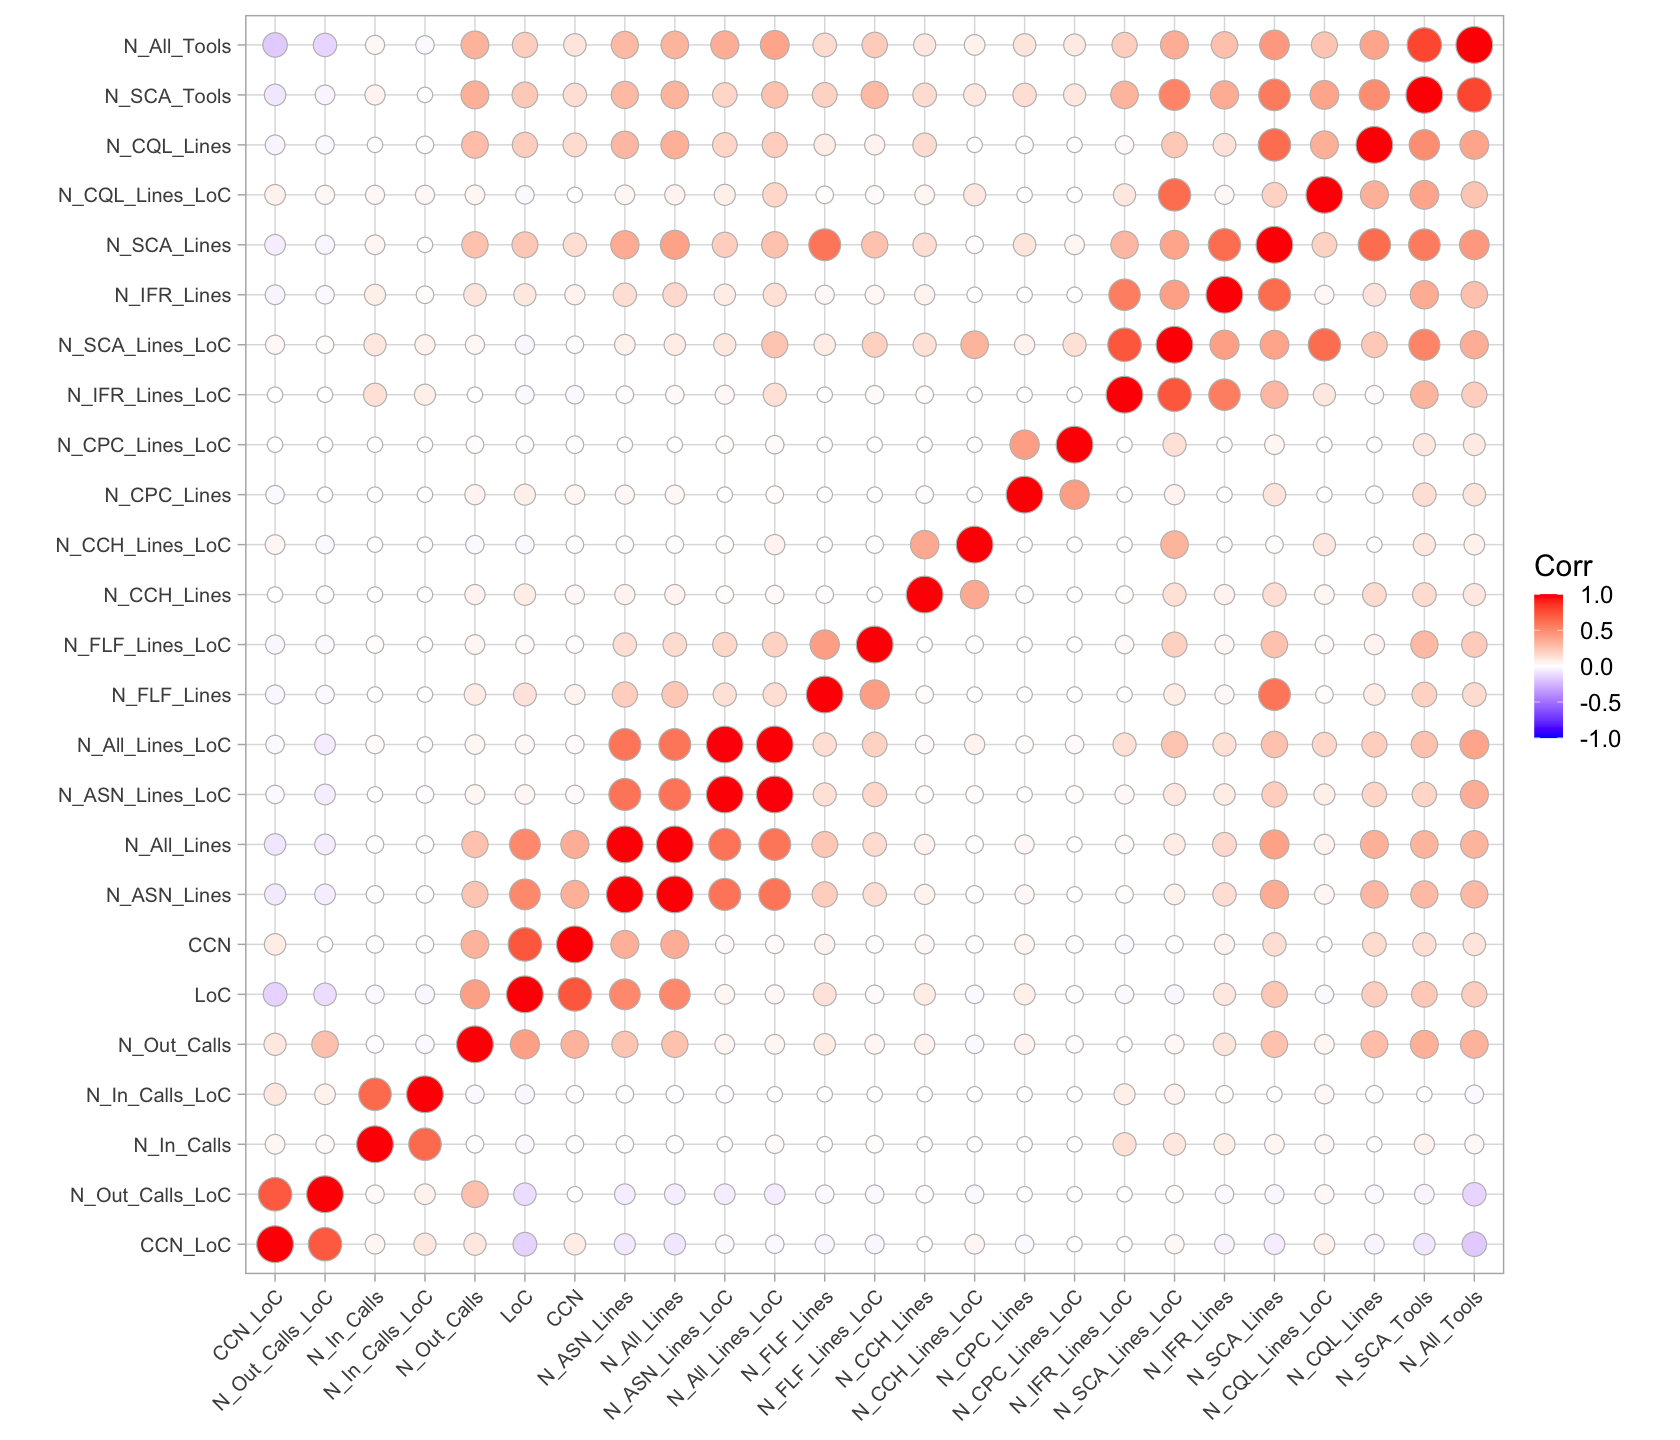

In [25]:
corr_matrix <- cor(ml_training_feature_data, method = "pearson")

options(repr.plot.width = 14, repr.plot.height = 12)
ggcorrplot(corr_matrix, method = "circle", hc.order = TRUE, lab = FALSE, ggtheme = my_theme)

##### Training

In [26]:
ml <- list()

if (USE_PRETRAINED_MODELS) {
    ml$rnd$model <- load_model("./models/rnd_model.rds")
    ml$glm$model <- load_model("./models/glm_model.rds")
    ml$mlp$model <- load_model("./models/mlp_model.rds")
    ml$rdf$model <- load_model("./models/rdf_model.rds")
    ml$svm$model <- load_model("./models/svm_model.rds")
    ml$gbm$model <- load_model("./models/gbm_model.rds")
} else {
    n_splits <- 10
    n_repetitions <- 5

    set.seed(42)

    train_control <- trainControl(
        index = createFolds(factor(ml_training_data$Is_Vuln), n_splits, returnTrain = TRUE),
        method = "repeatedcv",
        number = n_splits,
        repeats = n_repetitions,
        classProbs = TRUE,
        savePredictions = TRUE,
        summaryFunction = twoClassSummary,
        sampling = "down"
    )

    pp_flags <- c("zv", "nzv", "corr", "range")

    train_model(ml$rnd$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = rand, preProc = pp_flags, trControl = train_control))
    train_model(ml$rnd$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = rand, preProc = pp_flags, trControl = train_control, tuneGrid = data.frame(P1 = p_vuln, P2 = p_not_vuln)))
    train_model(ml$glm$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = "glm", preProc = pp_flags, trControl = train_control))
    train_model(ml$rdf$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = "rf", preProc = pp_flags, search = "grid", trControl = train_control))
    train_model(ml$svm$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = "svmLinear", preProc = pp_flags, search = "grid", trControl = train_control))
    train_model(ml$mlp$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = "mlpML", preProc = pp_flags, search = "grid", trControl = train_control))
    train_model(ml$gbm$model <- caret::train(Is_Vuln ~ ., data = ml_training_data, method = "gbm", preProc = pp_flags, trControl = train_control, verbose = FALSE))

    if (SAVE_MODELS) {
        save_model(ml$rnd$model, "./models/rnd_model.rds")
        save_model(ml$glm$model, "./models/glm_model.rds")
        save_model(ml$mlp$model, "./models/mlp_model.rds")
        save_model(ml$rdf$model, "./models/rdf_model.rds")
        save_model(ml$svm$model, "./models/svm_model.rds")
        save_model(ml$gbm$model, "./models/gbm_model.rds")
    }
}

### Vulnerability Prediction

In [27]:
if (USE_PRETRAINED_MODELS) {
    ml_vuln_prediction <- read.csv("./data/ml_vuln_prediction.csv")
} else {
    ml_vuln_prediction <- bind_rows(
        unnest(add_predictions(model = ml$rnd$model, data = ml_prediction_data, type = "prob")) |>
            mutate(Model = "rnd") |> rename(Prob_Vuln = yes) |> select(Subject, Function, Prob_Vuln, Model),
        unnest(add_predictions(model = ml$glm$model, data = ml_prediction_data, type = "prob")) |>
            mutate(Model = "glm") |> rename(Prob_Vuln = yes) |> select(Subject, Function, Prob_Vuln, Model),
        unnest(add_predictions(model = ml$mlp$model, data = ml_prediction_data, type = "prob")) |>
            mutate(Model = "mlp") |> rename(Prob_Vuln = yes) |> select(Subject, Function, Prob_Vuln, Model),
        unnest(add_predictions(model = ml$rdf$model, data = ml_prediction_data, type = "prob")) |>
            mutate(Model = "rdf") |> rename(Prob_Vuln = yes) |> select(Subject, Function, Prob_Vuln, Model),
        unnest(add_predictions(model = ml$svm$model, data = ml_prediction_data, type = "prob")) |>
            mutate(Model = "svm") |> rename(Prob_Vuln = yes) |> select(Subject, Function, Prob_Vuln, Model),
        unnest(add_predictions(model = ml$gbm$model, data = ml_prediction_data, type = "prob")) |>
            mutate(Model = "gbm") |> rename(Prob_Vuln = yes) |> select(Subject, Function, Prob_Vuln, Model)
    )

    if (SAVE_MODELS) {
        write.csv(ml_vuln_prediction, "./data/ml_vuln_prediction.csv", row.names = FALSE)
    }
}

head(ml_vuln_prediction)

,Subject,Function,Prob_Vuln,Model
,<chr>,<chr>,<dbl>,<chr>
1,LibTIFF,port/dummy.c:libport_dummy_function,1,rnd
2,LibTIFF,libtiff/tif_aux.c:_TIFFMultiply32,1,rnd
3,LibTIFF,libtiff/tif_error.c:TIFFErrorExt,1,rnd
4,LibTIFF,libtiff/tif_aux.c:_TIFFMultiply64,1,rnd
5,LibTIFF,libtiff/tif_aux.c:_TIFFMultiplySSize,1,rnd
6,LibTIFF,libtiff/tif_aux.c:_TIFFCastUInt64ToSSize,1,rnd


### Evaluation (Vulnerability Prediction Performance)

#### Training Set

In [28]:
ml_res_data1 <- data.frame()
ml_roc_data1 <- data.frame()

for (itm in ml) {
    ml_res_data1 <- bind_rows(ml_res_data1, mutate(itm$model$pred, Method = itm$model$modelInfo$label, AUC = mean(itm$model$results$ROC)))

    roc <- roc(response = itm$model$pred$obs, predictor = itm$model$pred$yes)
    ml_roc_data1 <- bind_rows(ml_roc_data1, data.frame(TPR = roc$specificities, FPR = 1 - roc$sensitivities, Cutoff = roc$thresholds) |>
        mutate(Method = itm$model$modelInfo$label))
}

ml_res_data1 <- ml_res_data1 |>
    rowwise() |>
    mutate(Name = model_name_map[[Method]])
ml_res_data1$Name <- factor(ml_res_data1$Name, levels = model_names)

head(ml_res_data1)

ml_roc_data1 <- ml_roc_data1 |>
    rowwise() |>
    mutate(Name = model_name_map[[Method]])
ml_roc_data1$Name <- factor(ml_roc_data1$Name, levels = model_names)

head(ml_roc_data1)

ml_auc_data1 <- ml_res_data1 |>
    select(Name, AUC) |>
    distinct()
ml_auc_data1$Name <- factor(ml_auc_data1$Name, levels = model_names)

ml_auc_data1

Setting levels: control = yes, case = no

Setting direction: controls < cases

Setting levels: control = yes, case = no

Setting direction: controls > cases

Setting levels: control = yes, case = no

Setting direction: controls > cases

Setting levels: control = yes, case = no

Setting direction: controls > cases

Setting levels: control = yes, case = no

Setting direction: controls > cases

Setting levels: control = yes, case = no

Setting direction: controls > cases



pred,obs,yes,no,rowIndex,P1,P2,Resample,Method,AUC,⋯,layer1,layer2,layer3,mtry,C,shrinkage,interaction.depth,n.minobsinnode,n.trees,Name
<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
yes,no,1,0,11,0.00274476,0.9972552,Fold01,C2: Random,0.5014103,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Random Classifier
yes,no,1,0,18,0.00274476,0.9972552,Fold01,C2: Random,0.5014103,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Random Classifier
yes,yes,1,0,24,0.00274476,0.9972552,Fold01,C2: Random,0.5014103,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Random Classifier
yes,no,1,0,29,0.00274476,0.9972552,Fold01,C2: Random,0.5014103,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Random Classifier
yes,no,1,0,30,0.00274476,0.9972552,Fold01,C2: Random,0.5014103,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Random Classifier
yes,no,1,0,38,0.00274476,0.9972552,Fold01,C2: Random,0.5014103,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Random Classifier


TPR,FPR,Cutoff,Method,Name
<dbl>,<dbl>,<dbl>,<chr>,<fct>
0,0.0000000000,-Inf,C2: Random,Random Classifier
0,0.0028205536,0.5,C2: Random,Random Classifier
1,1.0000000000,Inf,C2: Random,Random Classifier
0,0.0000000000,Inf,Generalized Linear Model,Generalized Linear Model
0,0.0004321816,1.0,Generalized Linear Model,Generalized Linear Model
0,0.0004549280,1.0,Generalized Linear Model,Generalized Linear Model


Name,AUC
<fct>,<dbl>
Random Classifier,0.5014103
Generalized Linear Model,0.8246831
Multi-Layer Perceptron,0.8351186
Random Decision Forest,0.8411452
Support Vector Machine,0.8327247
Stochastic Grad. Boosting,0.8454481


Saving 7.7 x 7.7 in image


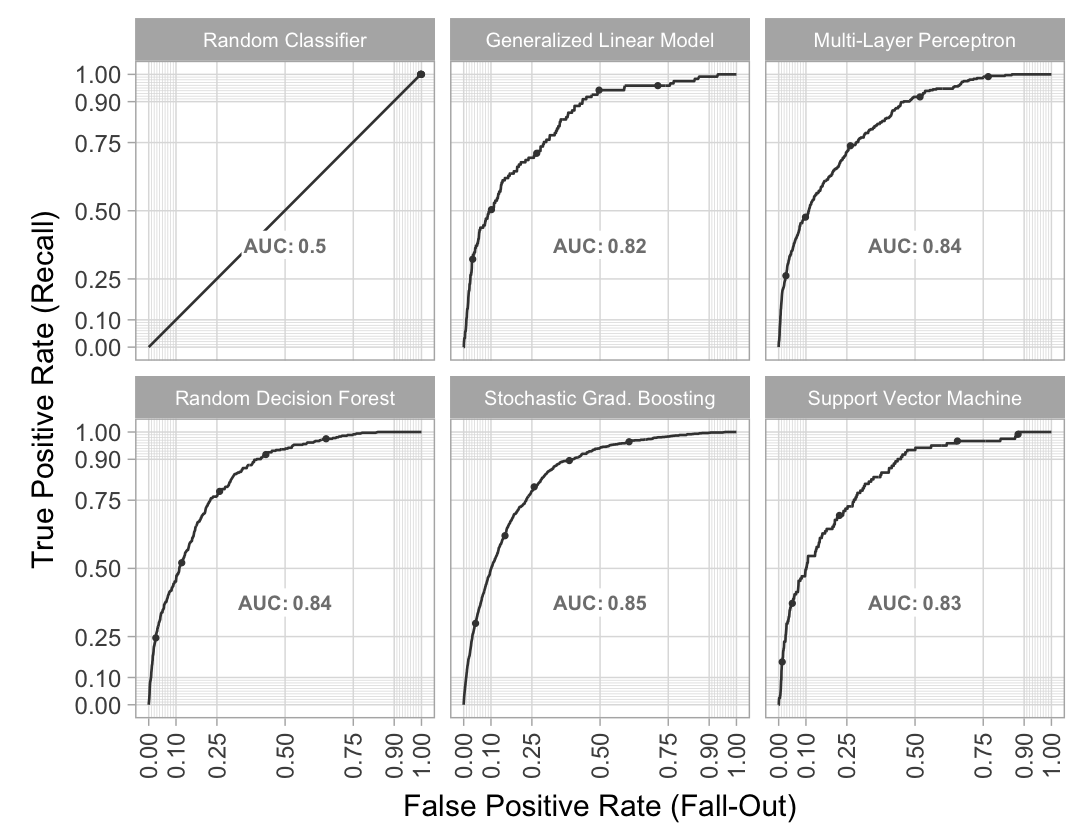

In [29]:
options(repr.plot.width = 9, repr.plot.height = 7)

ml_res_data1 |>
    ggplot() +
        style_roc(xlab = "False Positive Rate (Fall-Out)", ylab = "True Positive Rate (Recall)", guide = FALSE, theme = my_theme) +
        geom_roc(aes(m = yes, d = obs), cutoffs.at = seq(0.1, 0.9, 0.2), labels = FALSE, color = "gray25", size = 0.75, pointsize = 0.4) +
        geom_richtext(data = ml_auc_data1, aes(label = paste("AUC:", round(AUC, 2))), x = 0.5, y = 0.375, label.color = NA, fontface = "bold", size = 4.25, fill = "white", color = "gray50", label.padding = unit(c(0.3, 0.1, 0.1, 0.1), "lines")) +
        facet_wrap(Name ~ ., nrow = 2) +
        coord_equal() +
        theme(strip.text = element_text(size = 12)) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

ggsave(figure_path("fig5-1a"), width = 7, scale = 1.1)

#### Testing Set

In [30]:
ml_testing_subjects <- c("Libxml2", "LibTIFF", "nm", "objdump", "size")
ml_testing_funcs <- function_info |>
    filter(Subject %in% ml_testing_subjects)

head(ml_testing_funcs)

ml_testing_data <- merge(ml_testing_funcs, ml_feature_data, by = c("Function")) |>
    rename(Subject = Subject.y) |>
    select(Subject, Function, Is_Vuln) |>
    mutate(Is_Vuln = ifelse(Is_Vuln == "yes", TRUE, FALSE))

head(ml_testing_data)

,Subject,Function
,<chr>,<chr>
1,LibTIFF,port/dummy.c:libport_dummy_function
2,LibTIFF,libtiff/tif_aux.c:_TIFFMultiply32
3,LibTIFF,libtiff/tif_error.c:TIFFErrorExt
4,LibTIFF,libtiff/tif_aux.c:_TIFFMultiply64
5,LibTIFF,libtiff/tif_aux.c:_TIFFMultiplySSize
6,LibTIFF,libtiff/tif_aux.c:_TIFFCastUInt64ToSSize


,Subject,Function,Is_Vuln
,<chr>,<chr>,<lgl>
1,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE
2,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE
3,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE
4,Binutils,bfd/aout-target.h:i386_aout_linux_mkobject,FALSE
5,Binutils,bfd/aout-target.h:i386_aout_linux_mkobject,FALSE
6,Binutils,bfd/aout-target.h:i386_aout_linux_mkobject,FALSE


In [31]:
ml_res_data2 <- merge(ml_testing_data, ml_vuln_prediction, by = c("Subject", "Function"))

head(ml_res_data2)

,Subject,Function,Is_Vuln,Prob_Vuln,Model
,<chr>,<chr>,<lgl>,<dbl>,<chr>
1,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE,0.5233104,gbm
2,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE,0.4980000,rdf
3,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE,0.3529449,mlp
4,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE,0.2615872,glm
5,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE,1.0000000,rnd
6,Binutils,bfd/aout-target.h:i386_aout_linux_callback,FALSE,0.7835291,svm


In [32]:
ml_res_data2$Subject <- recode(ml_res_data2$Subject,
    Binutils = "nm, objdump, size"
)

ml_res_data2$Model <- factor(ml_res_data2$Model, levels = c("rnd", "glm", "mlp", "rdf", "gbm", "svm"))
ml_res_data2$Model <- recode(ml_res_data2$Model,
    rnd = "Random Classifier",
    gbm = "Stochastic Grad. Boosting",
    glm = "Generalized Linear Model",
    mlp = "Multi-Layer Perceptron",
    rdf = "Random Decision Forest",
    svm = "Support Vector Machine"
)

In [33]:
ml_auc_data2 <- ml_res_data2 |>
    group_by(Subject, Model) |>
    summarise(AUC = Metrics::auc(Is_Vuln, Prob_Vuln))

ml_auc_data2

`summarise()` has grouped output by 'Subject'. You can override using the
`.groups` argument.


Subject,Model,AUC
<chr>,<fct>,<dbl>
LibTIFF,Random Classifier,0.5006227
LibTIFF,Generalized Linear Model,0.7774649
LibTIFF,Multi-Layer Perceptron,0.7033407
LibTIFF,Random Decision Forest,0.7293573
LibTIFF,Stochastic Grad. Boosting,0.6560182
LibTIFF,Support Vector Machine,0.6382046
Libxml2,Random Classifier,0.5008443
Libxml2,Generalized Linear Model,0.7780994
Libxml2,Multi-Layer Perceptron,0.8485872


Saving 14.3 x 7.7 in image


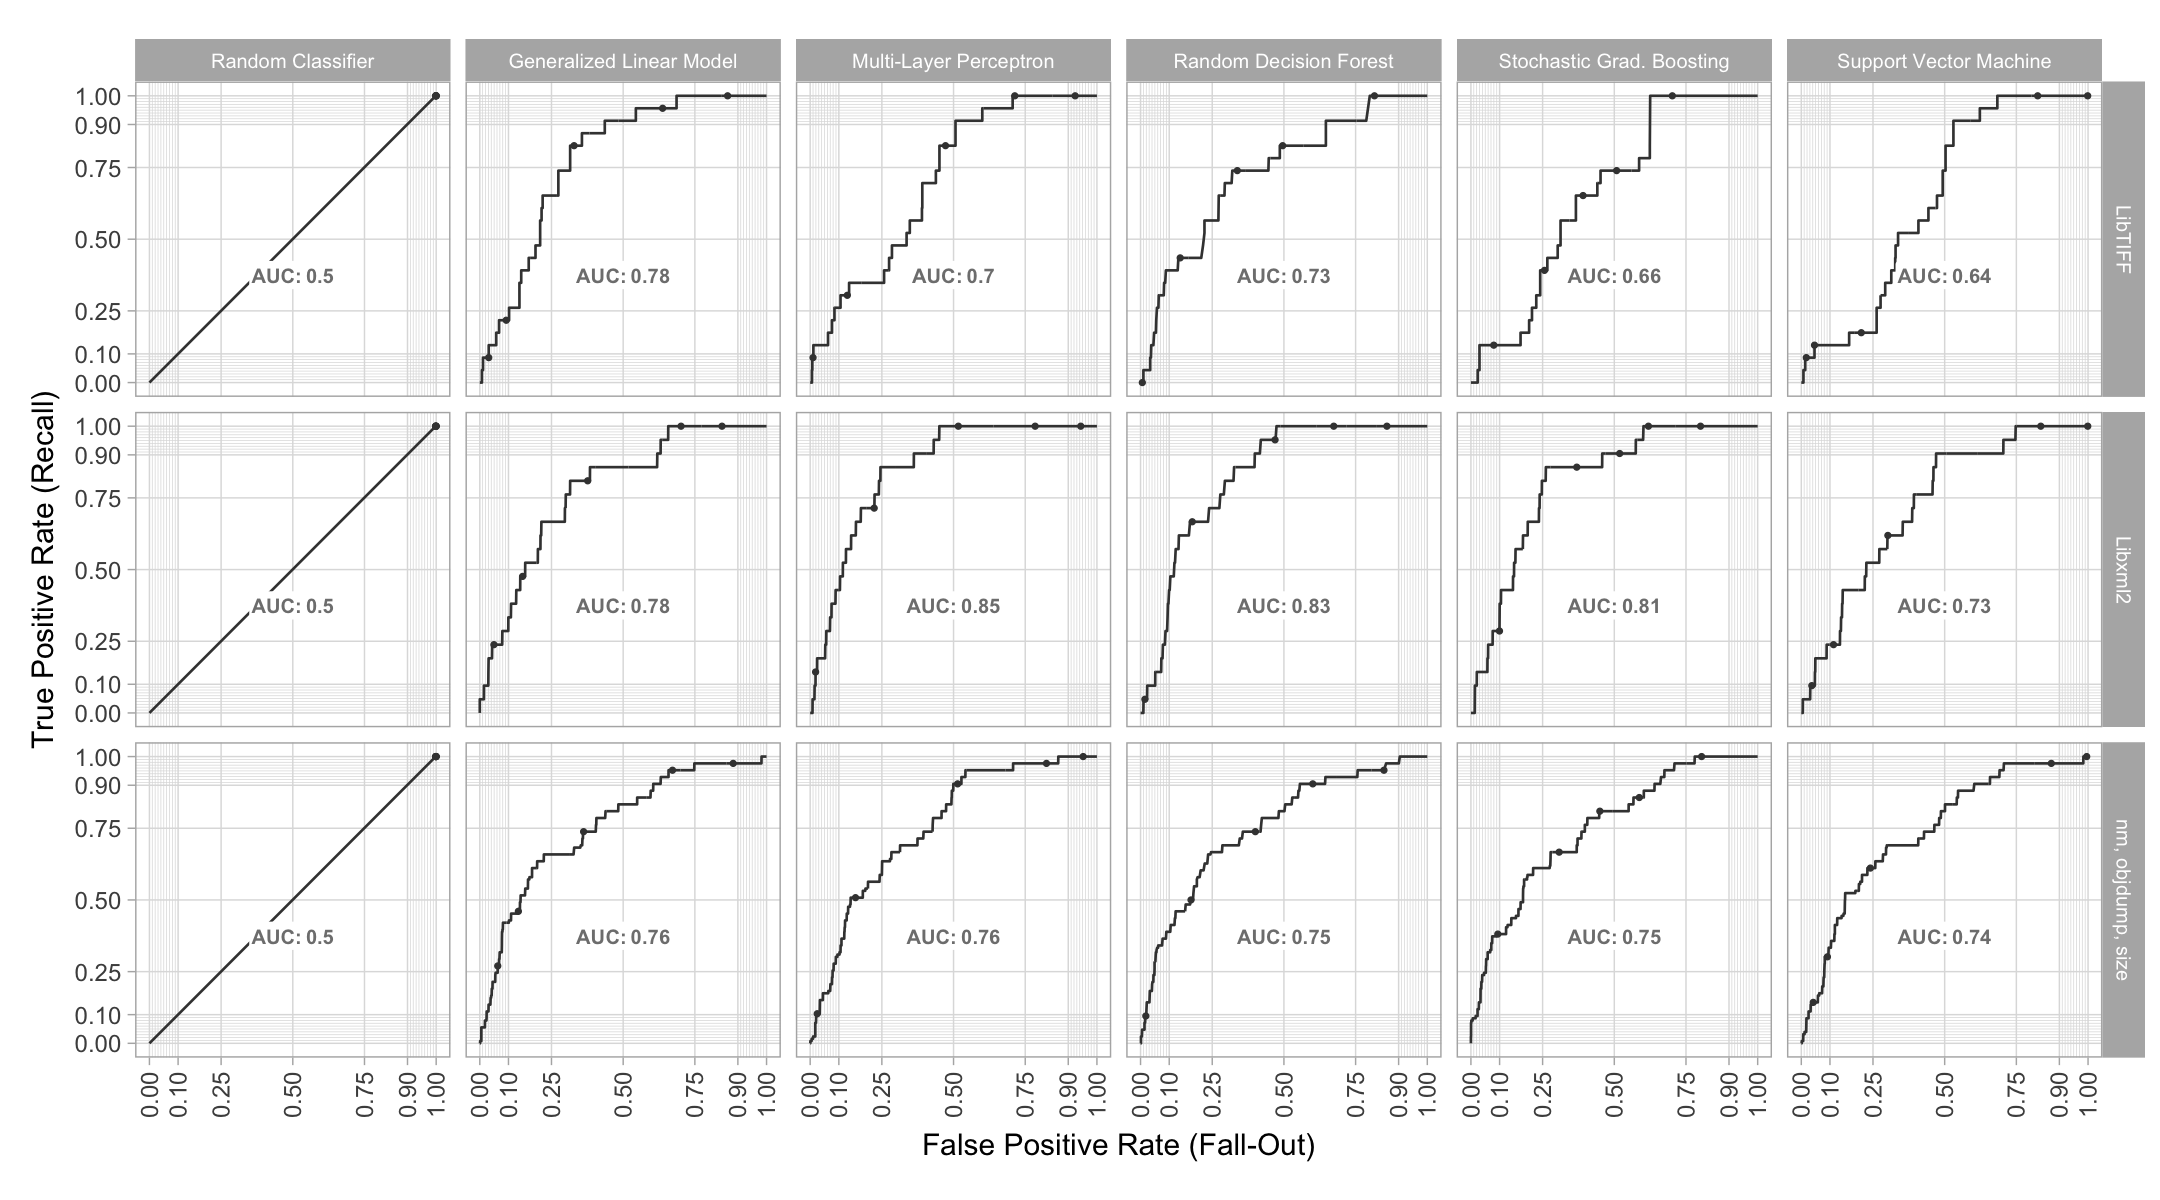

In [34]:
options(repr.plot.width = 18, repr.plot.height = 10)

ml_res_data2 |>
    ggplot() +
        style_roc(xlab = "False Positive Rate (Fall-Out)", ylab = "True Positive Rate (Recall)", guide = FALSE, theme = my_theme) +
        geom_roc(aes(m = Prob_Vuln, d = Is_Vuln), cutoffs.at = seq(0.1, 0.9, 0.2), labels = FALSE, color = "gray25", size = 0.75, pointsize = 0.4) +
        geom_richtext(data = ml_auc_data2, aes(label = paste("AUC:", round(AUC, 2))), x = 0.5, y = 0.375, label.color = NA, fontface = "bold", size = 4.25, fill = "white", color = "gray50", label.padding = unit(c(0.3, 0.1, 0.1, 0.1), "lines")) +
        facet_grid(Subject ~ Model) +
        coord_equal() +
        theme(strip.text  = element_text(size = 12)) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

ggsave(figure_path("fig5-1b"), width = 13, scale = 1.1)

## Fuzzing Saturation / Stopping Criteria Analysis

---

**Script Options:**

In [35]:
# If set to TRUE, the already generated fuzzer saturation data are used for the tradeoff analysis (time savings
# vs. missed bugs). Otherwise, the saturation data will be newly generated (FALSE).
USE_EXISTING_SATURATION_DATA = TRUE

# If set to TRUE, the (newly generated) fuzzer saturation data will be stored to the current working directory,
# otherwise not (FALSE).
SAVE_SATURATION_DATA = FALSE

---

In [36]:
(ml_model_config = read.csv("./data/ml_model_config.csv"))

Subject,Model,N_Marked_Fcts,N_All_Fcts,Ratio_Marked_Fcts,N_Marked_Bugs,N_All_Bugs,Ratio_Marked_Bugs,Cutoff,Token
<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
Gif2png,mlp,27,39,0.69230769,3,3,1.0000000,0.4,Gif2png-mlp-0.4
JasPer,rdf,484,667,0.72563718,38,41,0.9268293,0.2,JasPer-rdf-0.2
Libpcap,gbm,55,386,0.14248705,3,3,1.0000000,0.5,Libpcap-gbm-0.5
LibTIFF,rdf,85,632,0.13449367,4,4,1.0000000,0.7,LibTIFF-rdf-0.7
Libxml2,gbm,305,888,0.34346847,5,5,1.0000000,0.8,Libxml2-gbm-0.8
nm,rdf,150,1772,0.08465011,2,2,1.0000000,0.8,nm-rdf-0.8
objdump,mlp,1265,2355,0.53715499,3,3,1.0000000,0.5,objdump-mlp-0.5
size,rdf,132,1542,0.08560311,2,2,1.0000000,0.8,size-rdf-0.8


In [37]:
if (!file.exists("./data/fuzzer_cov_data.csv") & file.exists("./data/fuzzer_cov_data.csv.xz")) {
    system("cd ./data; unxz ./fuzzer_cov_data.csv.xz; cd -")
}

fuzzer_cov_data <- read.csv("./data/fuzzer_cov_data.csv") |>
    mutate(Token = paste(Subject, Model, Cutoff, sep = "-")) |>
    filter(Token %in% ml_model_config$Token) |>
    filter(!Fuzzer %in% c("Eclipser"))

head(fuzzer_cov_data)

,Subject,Fuzzer,Seed_Type,Trial_Nr,Timeout,Model,Cutoff,N_Fct_Src_Cov,N_Fct_Src_All,Ratio_Fct_Src_Cov,⋯,N_Dfc_Bug_Cov,N_Dfc_Bug_All,Ratio_Dfc_Bug_Cov,N_Bug_Trg,N_Bug_All,Ratio_Bug_Trg,N_Crash_Trg,N_Crash_All,Ratio_Crash_Trg,Token
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,⋯,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>
1,Gif2png,AFL,non-empty,1,15,mlp,0.4,22,27,0.8148148,⋯,3,3,1,1,4,0.25,6,28,0.2142857,Gif2png-mlp-0.4
2,Gif2png,AFL,non-empty,1,30,mlp,0.4,22,27,0.8148148,⋯,3,3,1,1,4,0.25,10,28,0.3571429,Gif2png-mlp-0.4
3,Gif2png,AFL,non-empty,1,45,mlp,0.4,22,27,0.8148148,⋯,3,3,1,1,4,0.25,10,28,0.3571429,Gif2png-mlp-0.4
4,Gif2png,AFL,non-empty,1,60,mlp,0.4,22,27,0.8148148,⋯,3,3,1,1,4,0.25,10,28,0.3571429,Gif2png-mlp-0.4
5,Gif2png,AFL,non-empty,1,75,mlp,0.4,22,27,0.8148148,⋯,3,3,1,1,4,0.25,10,28,0.3571429,Gif2png-mlp-0.4
6,Gif2png,AFL,non-empty,1,90,mlp,0.4,22,27,0.8148148,⋯,3,3,1,1,4,0.25,10,28,0.3571429,Gif2png-mlp-0.4


In [38]:
mean_fuzzer_cov_data <- fuzzer_cov_data |>
    group_by(Subject, Fuzzer, Timeout) |>
    summarise(
        Mean.N_Fct_Src_Cov = mean(N_Fct_Src_Cov),
        Mean.N_Dfc_Src_Cov = mean(N_Dfc_Src_Cov),
        Mean.N_Bug_Trg = mean(N_Bug_Trg),
        Mean.N_Crash_Trg = mean(N_Crash_Trg)
    )

# --- Add data points for "Timeout = 0" ---
(subjects <- unique(mean_fuzzer_cov_data$Subject))
(fuzzers <- unique(mean_fuzzer_cov_data$Fuzzer))
(timeout <- c(0))

temp <- crossing(Subject = subjects, Fuzzer = fuzzers, Timeout = timeout) |>
    mutate(Mean.N_Fct_Src_Cov = 0,
           Mean.N_Dfc_Src_Cov = 0,
           Mean.N_Bug_Trg = 0,
           Mean.N_Crash_Trg = 0)

mean_fuzzer_cov_data = bind_rows(mean_fuzzer_cov_data, temp)
# -----------------------------------------

mean_fuzzer_cov_data = mean_fuzzer_cov_data |>
    pivot_longer(cols = c(Mean.N_Fct_Src_Cov, Mean.N_Dfc_Src_Cov, Mean.N_Bug_Trg, Mean.N_Crash_Trg),
                 names_to = "Type", values_to = "Value")

mean_fuzzer_cov_data = mean_fuzzer_cov_data |>
    group_by(Subject, Fuzzer, Type) |>
    mutate(Ratio = c_div(Value, max(Value)))

head(mean_fuzzer_cov_data)

`summarise()` has grouped output by 'Subject', 'Fuzzer'. You can override using
the `.groups` argument.


[1] "Gif2png" "JasPer"  "LibTIFF" "Libpcap" "Libxml2" "nm"      "objdump"
[8] "size"

[1] "AFL"        "AFL++"      "AFLFast"    "AFLSmart"   "FairFuzz"  
[6] "Honggfuzz"  "MOpt-AFL"   "MOpt-AFL++"

[1] 0

Subject,Fuzzer,Timeout,Type,Value,Ratio
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Gif2png,AFL,15,Mean.N_Fct_Src_Cov,22.00,1.0000000
Gif2png,AFL,15,Mean.N_Dfc_Src_Cov,14.00,1.0000000
Gif2png,AFL,15,Mean.N_Bug_Trg,1.05,0.5833333
Gif2png,AFL,15,Mean.N_Crash_Trg,7.10,0.3631714
Gif2png,AFL,30,Mean.N_Fct_Src_Cov,22.00,1.0000000
Gif2png,AFL,30,Mean.N_Dfc_Src_Cov,14.00,1.0000000


### Case Study

In [39]:
sep_char <- " \U2022 "

subject_fuzzer_cases <- c(
    paste("LibTIFF", "MOpt-AFL", sep = sep_char),
    paste("size", "FairFuzz", sep = sep_char),
    paste("nm", "AFLSmart", sep = sep_char),
    paste("size", "AFLSmart", sep = sep_char)
)

metrics <- c("Mean.N_Fct_Src_Cov", "Mean.N_Dfc_Src_Cov", "Mean.N_Crash_Trg", "Mean.N_Bug_Trg")

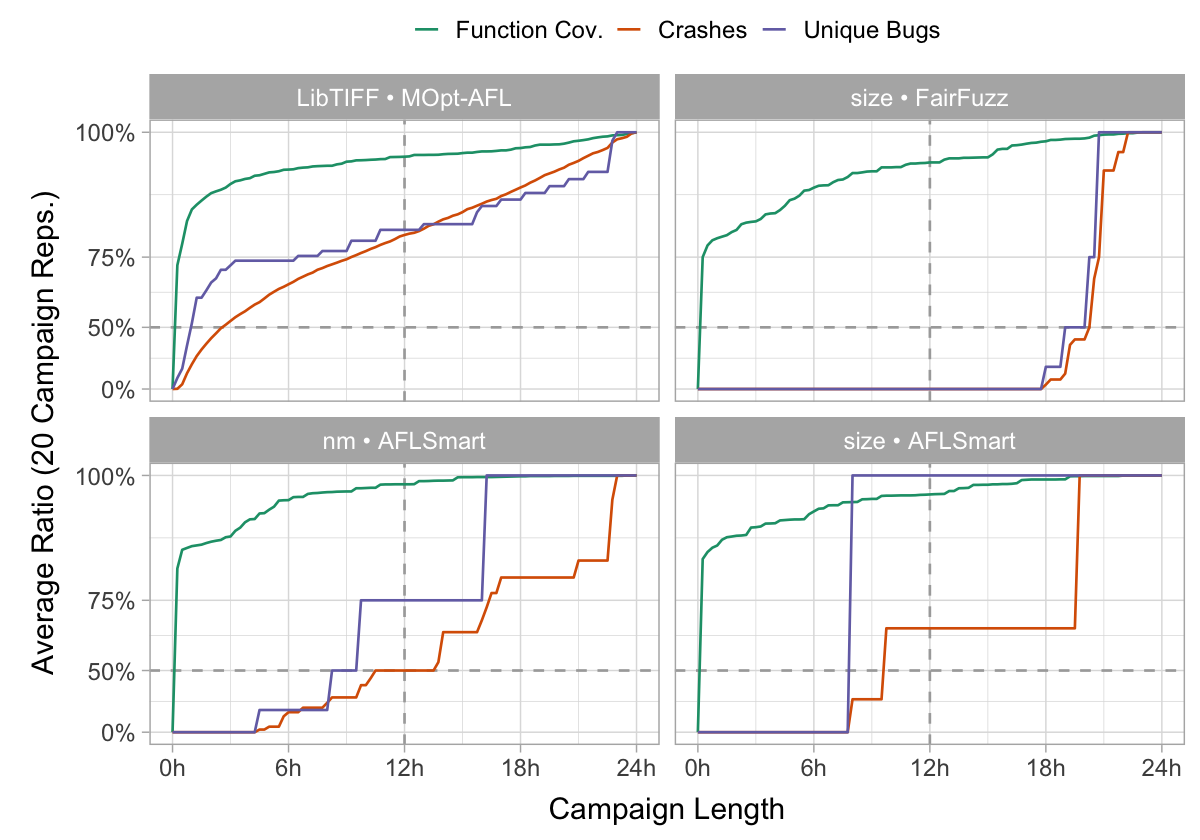

In [40]:
options(repr.plot.width = 10, repr.plot.height = 7)

mean_fuzzer_cov_data |>
    mutate(Token = paste(Subject, Fuzzer, sep = sep_char)) |>
    mutate(Token = factor(Token, subject_fuzzer_cases)) |>
    mutate(Type  = factor(Type, metrics)) |>
    filter(Token %in% subject_fuzzer_cases) |>
    filter(Type %in% c("Mean.N_Fct_Src_Cov", "Mean.N_Crash_Trg", "Mean.N_Bug_Trg")) |>
    ggplot(aes(x = Timeout / 60, y = Ratio)) +
        labs(x = "Campaign Length", y = "Average Ratio (20 Campaign Reps.)", color = "") +
        geom_vline(xintercept = 12, color = "darkgray", linetype = "dashed", linewidth = 0.75) +
        geom_hline(yintercept = .5, color = "darkgray", linetype = "dashed", linewidth = 0.75) +
        geom_line(aes(color = Type), linewidth = 0.75) +
        facet_wrap(Token ~ ., nrow = 2) +
        scale_x_continuous(labels = function(x) paste0(x, "h"), breaks = seq(0, 24, 6)) +
        scale_y_continuous(labels = scales::percent, trans = scales::exp_trans(10), breaks = c(0, 0.5, 0.75, 1)) +
        scale_color_brewer(palette = "Dark2", labels = c(Mean.N_Bug_Trg = "Unique Bugs", Mean.N_Crash_Trg = "Crashes", Mean.N_Fct_Src_Cov = "Function Cov.")) +
        theme(legend.position = "top")

ggsave(figure_path("fig2-1a"), width = 10, height = 7, device = cairo_pdf)

### Fuzzer Saturation Data

In [41]:
REQUIRED_DATA_POINTS = 96 # = (24 hour campaigns * 60 min) / 15 min interval

CAMPAIGN_LENGTH = 24 * 60 # Minutes

In [42]:
get_saturation_timeout <- function(campaign_data, metric, satur_len, delta = 0) {
    stopifnot(delta >= 0)
    stopifnot(nrow(campaign_data) == REQUIRED_DATA_POINTS)

    s <- (satur_len / 15)

    i <- s + 1

    # Loop through all data points of the fuzzing campaign
    while (i <= REQUIRED_DATA_POINTS) {
        
        # Check if the saturation-based stopping criterion is met, i.e., if the selected fuzzing effectiveness
        # metric (e.g., code coverage or number of crashes triggered) has not exceeded the specified allowable
        # delta within the saturation window.
        if (campaign_data[[i - s, metric]] >= (campaign_data[[i, metric]] - delta)) {
            
            # Return the time point when we can stop the campaign
            return(i * 15)
        }

        i <- i + 1
    }

    # ... no saturation has occurred within the campaign
    return(CAMPAIGN_LENGTH)
}

In [43]:
get_saturation_data <- function(cluster, config) {
    eval_data <- do.call(
        rbind,
        parSapply(
            cl = cluster,
            X = config,
            simplify = FALSE,
            FUN = function(input_vec) {
                get_num_of_bugs <- function(cov_data, timeout) {
                    t <- ifelse(timeout == -1, 24 * 60, timeout)
                    return(as.integer(filter(cov_data, Timeout == t)$N_Bug_Trg))
                }

                subject <- input_vec[[1]]
                fuzzer <- input_vec[[2]]
                trial_nr <- input_vec[[3]]

                cov_data <- fuzzer_cov_data |> filter(Subject == subject & Fuzzer == fuzzer & Trial_Nr == trial_nr)

                df <- data.frame()

                for (satur_len in (60 * seq(1, 10, 1))) {
                    for (delta in seq(0, 2, 1)) {
                        cr_timeout <- get_saturation_timeout(cov_data, "N_Crash_Trg", satur_len, delta)
                        fc_timeout <- get_saturation_timeout(cov_data, "N_Fct_Src_Cov", satur_len, delta)
                        dc_timeout <- get_saturation_timeout(cov_data, "N_Dfc_Src_Cov", satur_len, delta)

                        cr_n_bugs <- get_num_of_bugs(cov_data, cr_timeout)
                        fc_n_bugs <- get_num_of_bugs(cov_data, fc_timeout)
                        dc_n_bugs <- get_num_of_bugs(cov_data, dc_timeout)

                        df <- bind_rows(
                            df,
                            data.frame(
                                Subject = subject,
                                Fuzzer = fuzzer,
                                Trial_Nr = trial_nr,
                                Sat_Length = satur_len,
                                Delta = delta,
                                Crs_Trg_Timeout = cr_timeout,
                                Fct_Cov_Timeout = fc_timeout,
                                Dfc_Cov_Timeout = dc_timeout,
                                Crs_Trg_N_Bugs = cr_n_bugs,
                                Fct_Cov_N_Bugs = fc_n_bugs,
                                Dfc_Cov_N_Bugs = dc_n_bugs
                            )
                        )
                    }
                }

                return(df)
            }
        )
    )
    return(eval_data)
}

In [44]:
if (USE_EXISTING_SATURATION_DATA) {
    fuzzer_cov_saturation = read.csv("./data/fuzzer_cov_saturation.csv")
} else {
    system("rm -f tmp_log.txt")

    cluster <- makeCluster(detectCores() - 1, outfile = "./tmp_log.txt")

    # Load the required packages on every core in 'cluster'
    clusterEvalQ(
        cluster,
        pacman::p_load(tidyverse, dplyr, tidyr, stringr)
    )

    global_vars <- list(
        "REQUIRED_DATA_POINTS",
        "CAMPAIGN_LENGTH",
        "fuzzer_cov_data",
        "get_saturation_timeout"
    )

    clusterExport(cluster, global_vars, envir = globalenv())

    fuzzers <- unique(fuzzer_cov_data$Fuzzer)

    fuzzer_cov_saturation <- data.frame()

    for (subject in unique(fuzzer_cov_data$Subject)) {
        print(paste("-----", subject, "-----"))
        flush.console()

        config <- list()

        for (fuzzer in fuzzers) {
            for (trial_nr in seq(1, 20, 1)) {
                config <- append(config, list(c(subject, fuzzer, trial_nr)))
            }
        }
        temp_df <- get_saturation_data(cluster, config)

        fuzzer_cov_saturation <- bind_rows(fuzzer_cov_saturation, temp_df)
    }

    stopCluster(cluster)

    if (SAVE_SATURATION_DATA) {
        write.csv(fuzzer_cov_saturation, "./data/fuzzer_cov_saturation.csv", row.names = FALSE)
    }
}

head(fuzzer_cov_saturation)

,Subject,Fuzzer,Trial_Nr,Sat_Length,Delta,Crs_Trg_Timeout,Fct_Cov_Timeout,Dfc_Cov_Timeout,Crs_Trg_N_Bugs,Fct_Cov_N_Bugs,Dfc_Cov_N_Bugs,N_UCs,N_Diff_Bugs1,N_Diff_Bugs2,N_Diff_Timeout1,N_Diff_Timeout2,Ratio_Diff_Bugs1,Ratio_Diff_Bugs2,Ratio_Diff_Timeout1,Ratio_Diff_Timeout2
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gif2png,AFL,1,60,0,90,75,75,1,1,1,4,0,0,15,0,0,0,0.01041667,0
2,Gif2png,AFL,1,60,1,90,75,75,1,1,1,4,0,0,15,0,0,0,0.01041667,0
3,Gif2png,AFL,1,60,2,90,75,75,1,1,1,4,0,0,15,0,0,0,0.01041667,0
4,Gif2png,AFL,1,120,0,150,135,135,1,1,1,4,0,0,15,0,0,0,0.01041667,0
5,Gif2png,AFL,1,120,1,150,135,135,1,1,1,4,0,0,15,0,0,0,0.01041667,0
6,Gif2png,AFL,1,120,2,150,135,135,1,1,1,4,0,0,15,0,0,0,0.01041667,0


### Evaluation (Stopping Criterion Tradeoffs)

In [45]:
delta_exprs <- c(
    "0" = expression(epsilon * " = " * "0"),
    "1" = expression(epsilon * " = " * "1"),
    "2" = expression(epsilon * " = " * "2")
)

delta_exprs_str <- c(
    "0" = as.character(delta_exprs[1]),
    "1" = as.character(delta_exprs[2]),
    "2" = as.character(delta_exprs[3])
)

sat_length_exprs <- c(
    "2" = expression(delta * " = " * "2h"),
    "4" = expression(delta * " = " * "4h"),
    "6" = expression(delta * " = " * "6h"),
    "8" = expression(delta * " = " * "8h")
)

sat_length_exprs_str <- c(
    "2" = as.character(sat_length_exprs[1]),
    "4" = as.character(sat_length_exprs[2]),
    "6" = as.character(sat_length_exprs[3]),
    "8" = as.character(sat_length_exprs[4])
)

**Note:** Although we perform the *tradeoff analysis* with fuzzing campaigns launched with a *non-empty seed corpus*, to approximate the **upper bound of (detectable) bugs** per subject program, we use the total number of unique bugs provided by the (extended) `FuzzTastic` dataset, regardless of the seed corpus.

In [46]:
# To use total number of triggered unique bugs of only the campaigns launched with a non-empty seed corpus as upper bound, simply uncomment the
# corresponding line below (spoiler: the ratio of missed bugs hardly changes).
fuzzer_crashes = read.csv("./data/fuzzer_crashes.csv") |>
    # filter(Seed_Type == "non-empty") |>
    distinct(Subject, Bug_ID) |>
    group_by(Subject) |>
    summarise(N_Unique_Bugs = n())

fuzzer_crashes

Subject,N_Unique_Bugs
<chr>,<int>
Gif2png,4
JasPer,77
LibTIFF,7
Libpcap,7
Libxml2,9
nm,4
objdump,5
size,6


In [47]:
fuzzer_bug_info <- fuzzer_cov_data |>
    group_by(Subject, Fuzzer, Trial_Nr) |>
    slice_max(Timeout) |>
    group_by(Subject, Fuzzer) |>
    summarise(Found_Bugs = sum(N_Bug_Trg) > 0)

head(fuzzer_bug_info)

`summarise()` has grouped output by 'Subject'. You can override using the
`.groups` argument.


Subject,Fuzzer,Found_Bugs
<chr>,<chr>,<lgl>
Gif2png,AFL,TRUE
Gif2png,AFL++,TRUE
Gif2png,AFLFast,TRUE
Gif2png,AFLSmart,TRUE
Gif2png,FairFuzz,TRUE
Gif2png,Honggfuzz,TRUE


In [48]:
tradeoff_data <- fuzzer_cov_saturation |>
    merge(fuzzer_crashes, by = "Subject") |>
    merge(fuzzer_bug_info, by = c("Subject", "Fuzzer")) |>
    rowwise() |>
    mutate(N_Diff_Bugs1 = (Crs_Trg_N_Bugs - Dfc_Cov_N_Bugs),
           N_Diff_Bugs2 = (Fct_Cov_N_Bugs - Dfc_Cov_N_Bugs),
           N_Diff_Timeout1 = (Crs_Trg_Timeout - Dfc_Cov_Timeout),
           N_Diff_Timeout2 = (Fct_Cov_Timeout - Dfc_Cov_Timeout),
           Ratio_Diff_Bugs1 = c_div(N_Diff_Bugs1, N_Unique_Bugs),
           Ratio_Diff_Bugs2 = c_div(N_Diff_Bugs2, N_Unique_Bugs),
           Ratio_Diff_Timeout1 = (N_Diff_Timeout1 / CAMPAIGN_LENGTH),
           Ratio_Diff_Timeout2 = (N_Diff_Timeout2 / CAMPAIGN_LENGTH))

head(tradeoff_data)

Subject,Fuzzer,Trial_Nr,Sat_Length,Delta,Crs_Trg_Timeout,Fct_Cov_Timeout,Dfc_Cov_Timeout,Crs_Trg_N_Bugs,Fct_Cov_N_Bugs,⋯,N_Diff_Bugs1,N_Diff_Bugs2,N_Diff_Timeout1,N_Diff_Timeout2,Ratio_Diff_Bugs1,Ratio_Diff_Bugs2,Ratio_Diff_Timeout1,Ratio_Diff_Timeout2,N_Unique_Bugs,Found_Bugs
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
Gif2png,AFL,1,60,0,90,75,75,1,1,⋯,0,0,15,0,0,0,0.01041667,0,4,TRUE
Gif2png,AFL,1,60,1,90,75,75,1,1,⋯,0,0,15,0,0,0,0.01041667,0,4,TRUE
Gif2png,AFL,1,60,2,90,75,75,1,1,⋯,0,0,15,0,0,0,0.01041667,0,4,TRUE
Gif2png,AFL,1,120,0,150,135,135,1,1,⋯,0,0,15,0,0,0,0.01041667,0,4,TRUE
Gif2png,AFL,1,120,1,150,135,135,1,1,⋯,0,0,15,0,0,0,0.01041667,0,4,TRUE
Gif2png,AFL,1,120,2,150,135,135,1,1,⋯,0,0,15,0,0,0,0.01041667,0,4,TRUE


In [49]:
mean_tradeoff_data <- tradeoff_data |>
    group_by(Subject, Fuzzer, Sat_Length, Delta, N_Unique_Bugs, Found_Bugs) |>
    summarise(Mean.Ratio_Diff_Bugs1 = mean(Ratio_Diff_Bugs1),
              Mean.Ratio_Diff_Bugs2 = mean(Ratio_Diff_Bugs2),
              Mean.Ratio_Diff_Timeout1 = mean(Ratio_Diff_Timeout1),
              Mean.Ratio_Diff_Timeout2 = mean(Ratio_Diff_Timeout2),
              SD.Ratio_Diff_Bugs1 = sd(Ratio_Diff_Bugs1),
              SD.Ratio_Diff_Bugs2 = sd(Ratio_Diff_Bugs2),
              SD.Ratio_Diff_Timeout1 = sd(Ratio_Diff_Timeout1),
              SD.Ratio_Diff_Timeout2 = sd(Ratio_Diff_Timeout2))

head(mean_tradeoff_data)

`summarise()` has grouped output by 'Subject', 'Fuzzer', 'Sat_Length', 'Delta',
'N_Unique_Bugs'. You can override using the `.groups` argument.


Subject,Fuzzer,Sat_Length,Delta,N_Unique_Bugs,Found_Bugs,Mean.Ratio_Diff_Bugs1,Mean.Ratio_Diff_Bugs2,Mean.Ratio_Diff_Timeout1,Mean.Ratio_Diff_Timeout2,SD.Ratio_Diff_Bugs1,SD.Ratio_Diff_Bugs2,SD.Ratio_Diff_Timeout1,SD.Ratio_Diff_Timeout2
<chr>,<chr>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gif2png,AFL,60,0,4,TRUE,0.0000,0,0.020312500,0,0.0000000,0,0.020411016,0
Gif2png,AFL,60,1,4,TRUE,0.0000,0,0.014062500,0,0.0000000,0,0.012313577,0
Gif2png,AFL,60,2,4,TRUE,0.0000,0,0.008854167,0,0.0000000,0,0.008465914,0
Gif2png,AFL,120,0,4,TRUE,0.0125,0,0.045312500,0,0.0559017,0,0.075060511,0
Gif2png,AFL,120,1,4,TRUE,0.0000,0,0.031770833,0,0.0000000,0,0.052190132,0
Gif2png,AFL,120,2,4,TRUE,0.0000,0,0.015104167,0,0.0000000,0,0.023530214,0


#### Baseline: Crash Saturation

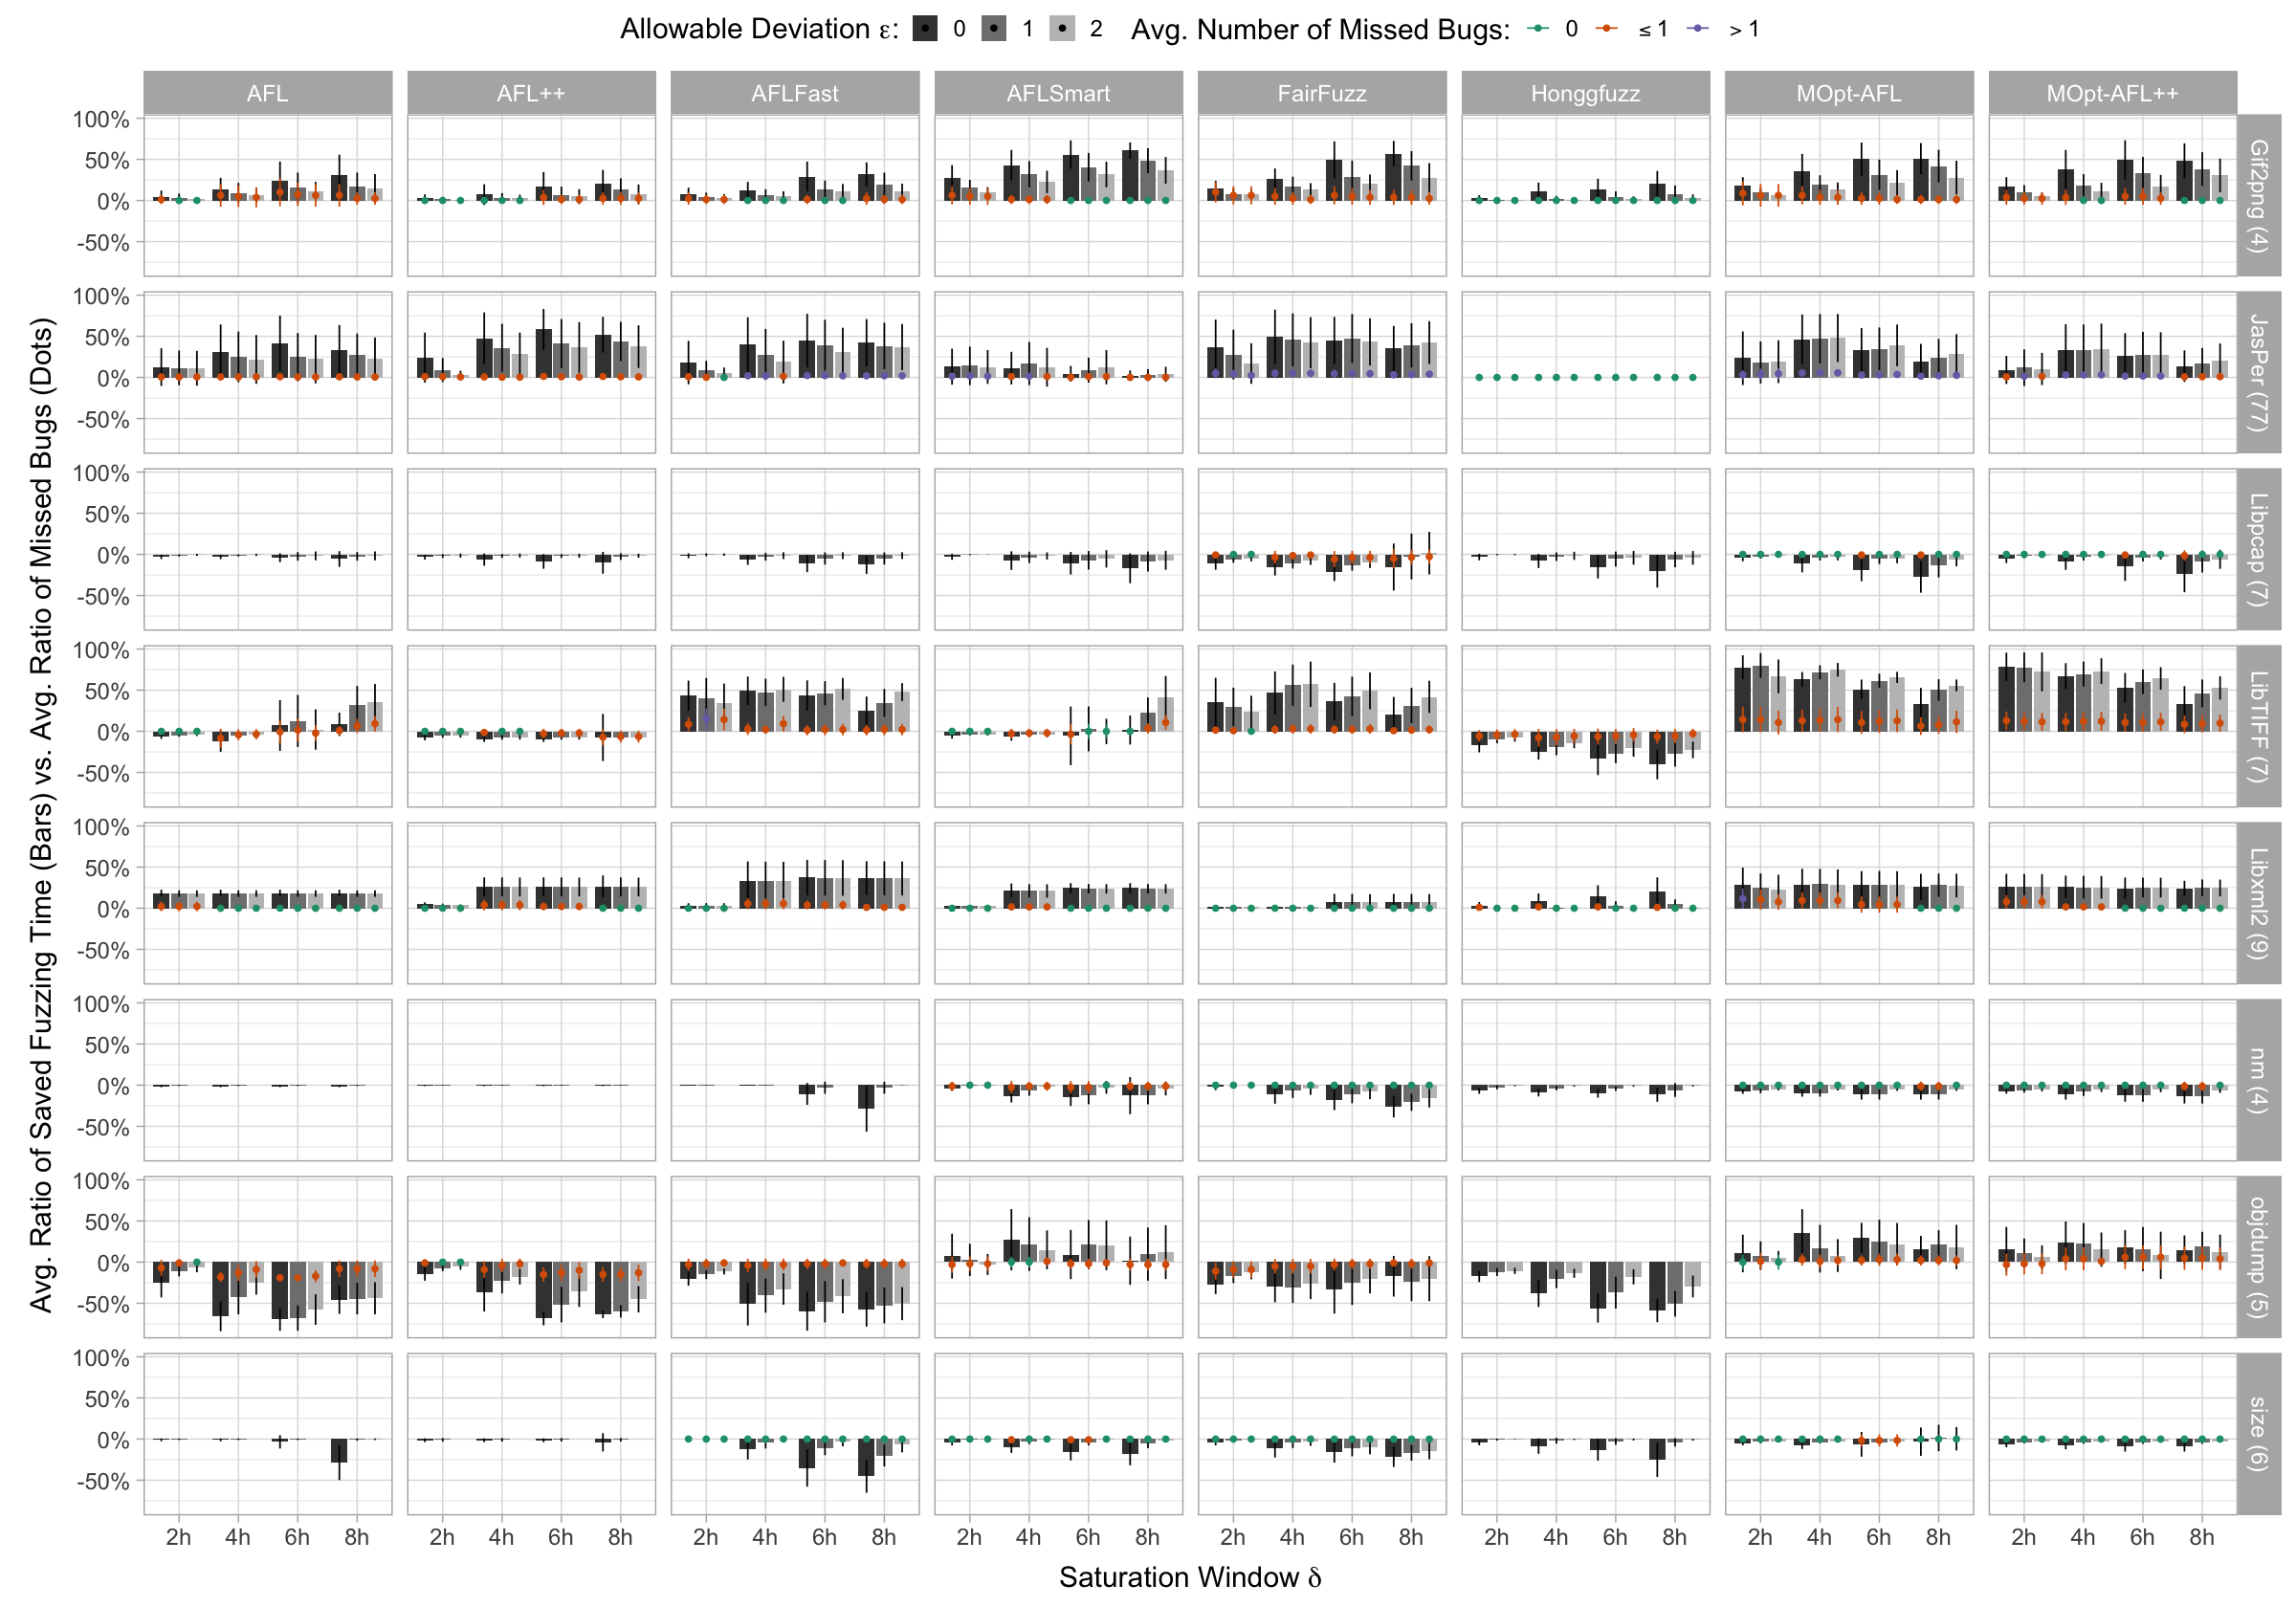

In [50]:
options(repr.plot.width = 20, repr.plot.height = 14)

mean_tradeoff_data |>
    mutate(Bug_Range = ifelse(Mean.Ratio_Diff_Bugs1 == 0, "A", ifelse(abs(Mean.Ratio_Diff_Bugs1) <= (1 / N_Unique_Bugs), "B", "C"))) |>
    mutate(Subject2 = paste(Subject, paste0("(", N_Unique_Bugs, ")"))) |>
    filter(Sat_Length %in% (60 * seq(2, 8, 2))) |>
    ggplot(aes(x = as.factor(Sat_Length / 60))) +
        labs(x = expression(paste("Saturation Window ", delta)), y = "Avg. Ratio of Saved Fuzzing Time (Bars) vs. Avg. Ratio of Missed Bugs (Dots)", fill = expression(paste("Allowable Deviation ", epsilon, ":", sep = "")), color = "Avg. Number of Missed Bugs:") +
        geom_col(aes(y = Mean.Ratio_Diff_Timeout1, fill = as.factor(Delta)), position = position_dodge2(width = 0.9, preserve = "single")) +
        geom_errorbar(aes(ymin = (Mean.Ratio_Diff_Timeout1 - SD.Ratio_Diff_Timeout1), ymax = (Mean.Ratio_Diff_Timeout1 + SD.Ratio_Diff_Timeout1), fill = as.factor(Delta)), color = "black", linewidth = 0.5, width = 0, position = position_dodge(0.9)) +
        geom_errorbar(aes(ymin = (Mean.Ratio_Diff_Bugs1 - SD.Ratio_Diff_Bugs1), ymax = (Mean.Ratio_Diff_Bugs1 + SD.Ratio_Diff_Bugs1), fill = as.factor(Delta), color = Bug_Range, alpha = Found_Bugs), linewidth = 0.5, width = 0, position = position_dodge(0.9)) +
        geom_point(aes(y = Mean.Ratio_Diff_Bugs1, fill = as.factor(Delta), color = Bug_Range, alpha = Found_Bugs), position = position_dodge2(width = 0.9, preserve = "single")) +
        facet_grid(Subject2 ~ Fuzzer) +
        scale_x_discrete(labels = function(x) paste0(x, "h")) +
        scale_y_continuous(labels = scales::percent) +
        scale_fill_manual(values = gray_color_tones) +
        scale_color_brewer(palette = "Dark2", labels = c("0", expression("" <= 1), expression("" > 1))) +
        scale_alpha_manual(values = c(0, 1)) +
        theme(legend.position = "top") +
        guides(fill = guide_legend(order = 1), color = guide_legend(order = 2), alpha = "none")

ggsave(figure_path("fig5-2a"), width = 20, height = 14)

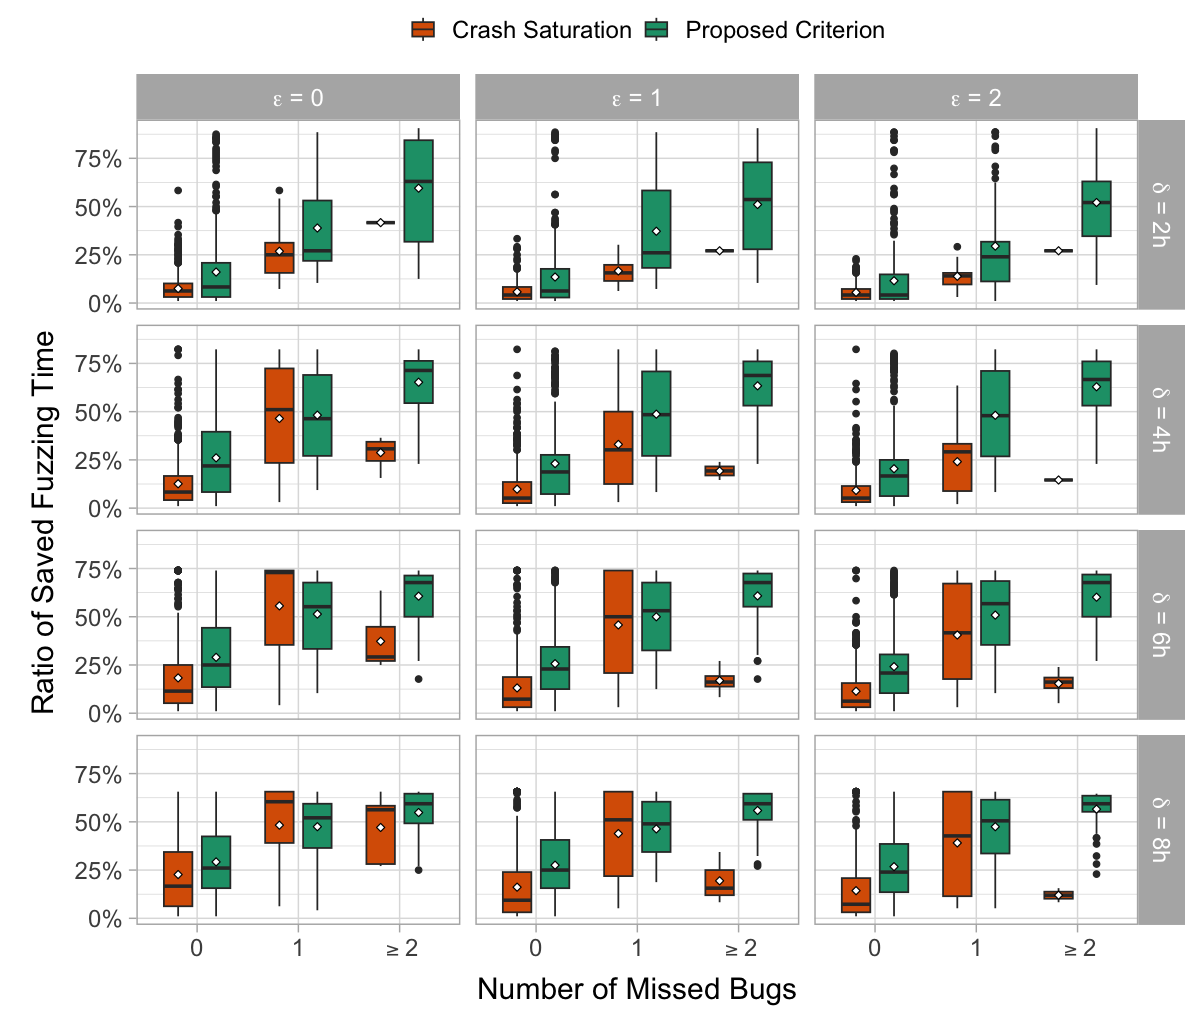

In [51]:
options(repr.plot.width = 10, repr.plot.height = 8.5)

tradeoff_data |>
    filter(Sat_Length %in% (60 * seq(2, 8, 2))) |>
    filter(Ratio_Diff_Timeout1 != 0) |>
    mutate(Sat_Length = Sat_Length / 60) |>
    mutate(N_Diff_Bug_Range1 = ifelse(abs(N_Diff_Bugs1) >= 2, "[2, Inf)", as.character(abs(N_Diff_Bugs1)))) |>
    mutate(N_Diff_Bug_Range1 = factor(N_Diff_Bug_Range1, levels = c("-2", "-1", "0", "1", "[2, Inf)"))) |>
    mutate(Criterion = ifelse(sign(Ratio_Diff_Timeout1) == -1, "Crash Saturation", "Proposed Criterion")) |>
    ggplot(aes(x = N_Diff_Bug_Range1, y = abs(Ratio_Diff_Timeout1), fill = Criterion, alpha = Criterion)) +
        labs(x = "Number of Missed Bugs", y = "Ratio of Saved Fuzzing Time", fill = "") +
        geom_boxplot(position = position_dodge2(padding = 0.25, preserve = "single")) +
        stat_summary(fun = mean, geom = "point", shape = 23, fill = "white", position = position_dodge2(width = .75, preserve = "single")) +
        facet_grid(Sat_Length ~ Delta, labeller = labeller(Sat_Length = as_labeller(sat_length_exprs_str, label_parsed), Delta = as_labeller(delta_exprs_str, label_parsed))) +
        scale_x_discrete(labels = c("0", "1", expression("" >= 2))) +
        scale_y_continuous(labels = scales::percent) +
        scale_fill_brewer(palette = "Dark2", direction = -1) +
        scale_alpha_manual(values = c(1, 1)) +
        theme(legend.position = "top") +
        guides(alpha = "none")

ggsave(figure_path("fig5-2b"), width = 10, height = 8.5)

#### Baseline: Function-Coverage Saturation

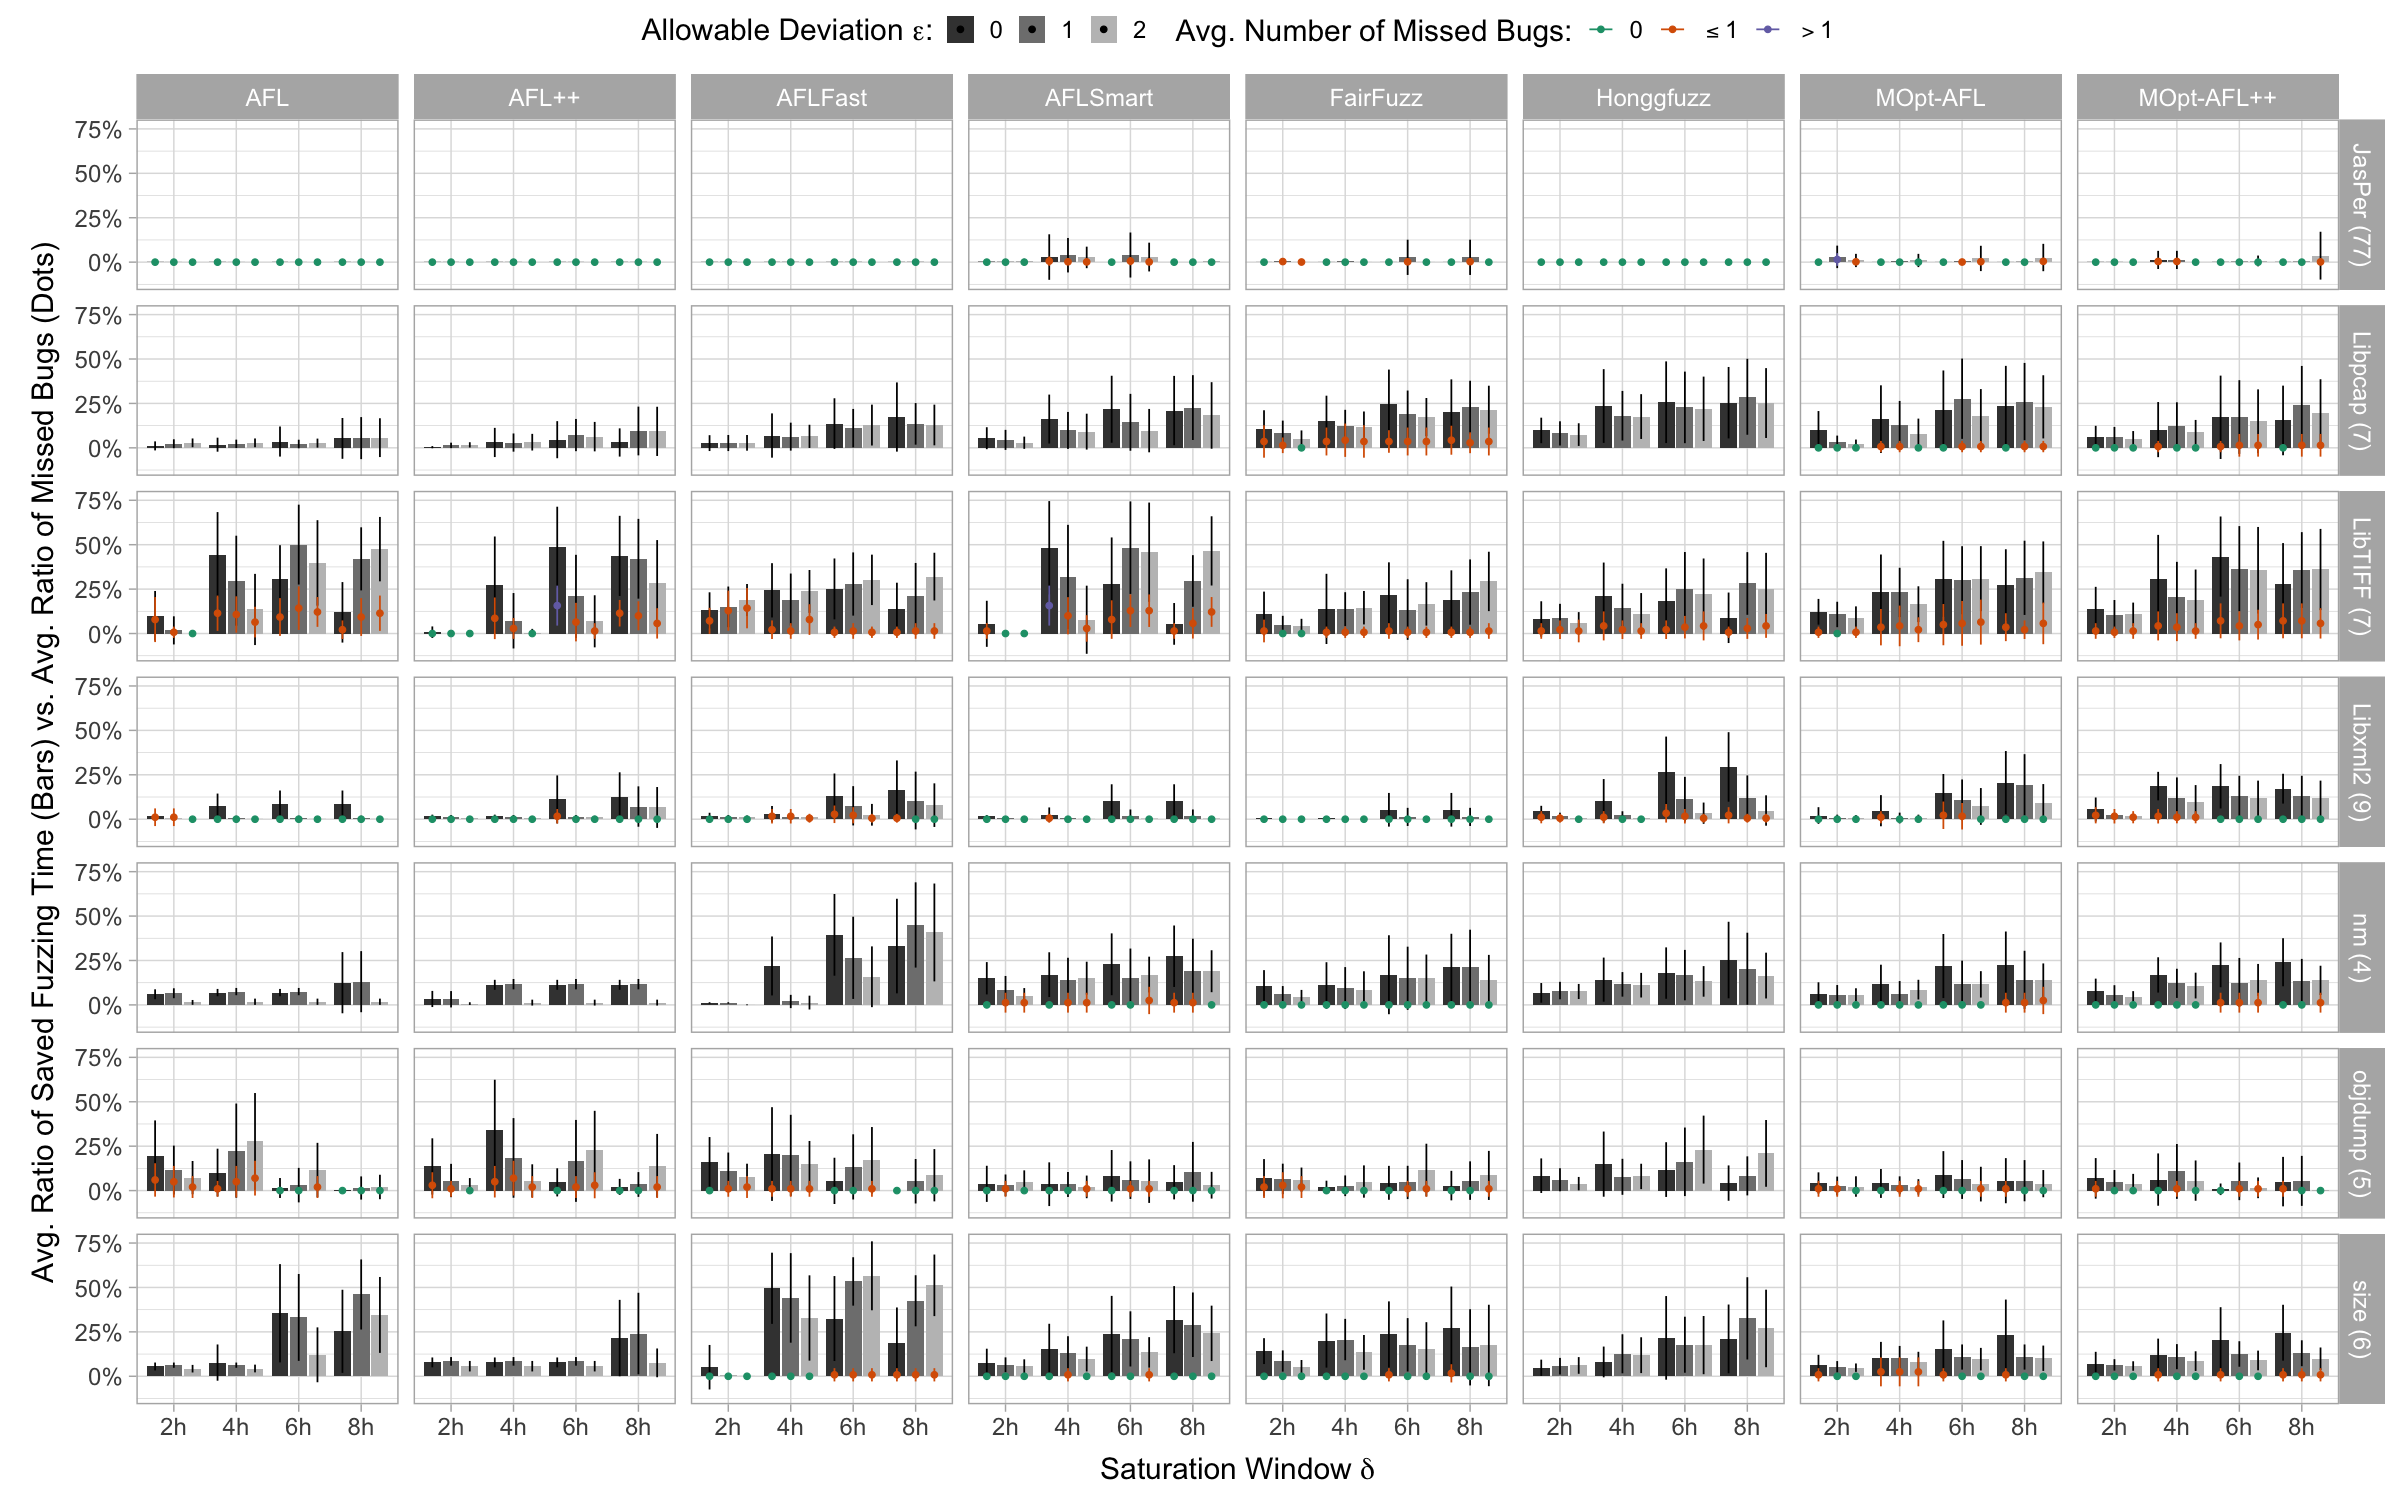

In [52]:
options(repr.plot.width = 20, repr.plot.height = 12.5)

mean_tradeoff_data |>
    mutate(Bug_Range = ifelse(Mean.Ratio_Diff_Bugs2 == 0, "A", ifelse(abs(Mean.Ratio_Diff_Bugs2) <= (1 / N_Unique_Bugs), "B", "C"))) |>
    mutate(Subject2 = paste(Subject, paste0("(", N_Unique_Bugs, ")"))) |>
    filter(!Subject %in% c("Gif2png")) |>
    filter(Sat_Length %in% (60 * seq(2, 8, 2))) |>
    ggplot(aes(x = as.factor(Sat_Length / 60))) +
        labs(x = expression(paste("Saturation Window ", delta)), y = "Avg. Ratio of Saved Fuzzing Time (Bars) vs. Avg. Ratio of Missed Bugs (Dots)", fill = expression(paste("Allowable Deviation ", epsilon, ":", sep = "")), color = "Avg. Number of Missed Bugs:") +
        geom_col(aes(y = Mean.Ratio_Diff_Timeout2, fill = as.factor(Delta)), position = position_dodge2(width = 0.9, preserve = "single")) +
        geom_errorbar(aes(ymin = (Mean.Ratio_Diff_Timeout2 - SD.Ratio_Diff_Timeout2), ymax = (Mean.Ratio_Diff_Timeout2 + SD.Ratio_Diff_Timeout2), fill = as.factor(Delta)), color = "black", linewidth = 0.5, width = 0, position = position_dodge(0.9)) +
        geom_errorbar(aes(ymin = (Mean.Ratio_Diff_Bugs2 - SD.Ratio_Diff_Bugs2), ymax = (Mean.Ratio_Diff_Bugs2 + SD.Ratio_Diff_Bugs2), fill = as.factor(Delta), color = Bug_Range, alpha = Found_Bugs), linewidth = 0.5, width = 0, position = position_dodge(0.9)) +
        geom_point(aes(y = Mean.Ratio_Diff_Bugs2, fill = as.factor(Delta), color = Bug_Range, alpha = Found_Bugs), position = position_dodge2(width = 0.9, preserve = "single")) +
        facet_grid(Subject2 ~ Fuzzer) +
        scale_x_discrete(labels = function(x) paste0(x, "h")) +
        scale_y_continuous(labels = scales::percent, breaks = seq(0, 0.75, 0.25)) +
        scale_fill_manual(values = gray_color_tones) +
        scale_color_brewer(palette = "Dark2", labels = c("0", expression("" <= 1), expression("" > 1))) +
        scale_alpha_manual(values = c(0, 1)) +
        theme(legend.position = "top") +
        guides(fill = guide_legend(order = 1), color = guide_legend(order = 2), alpha = "none")

ggsave(figure_path("fig5-2c"), width = 20, height = 12.5)

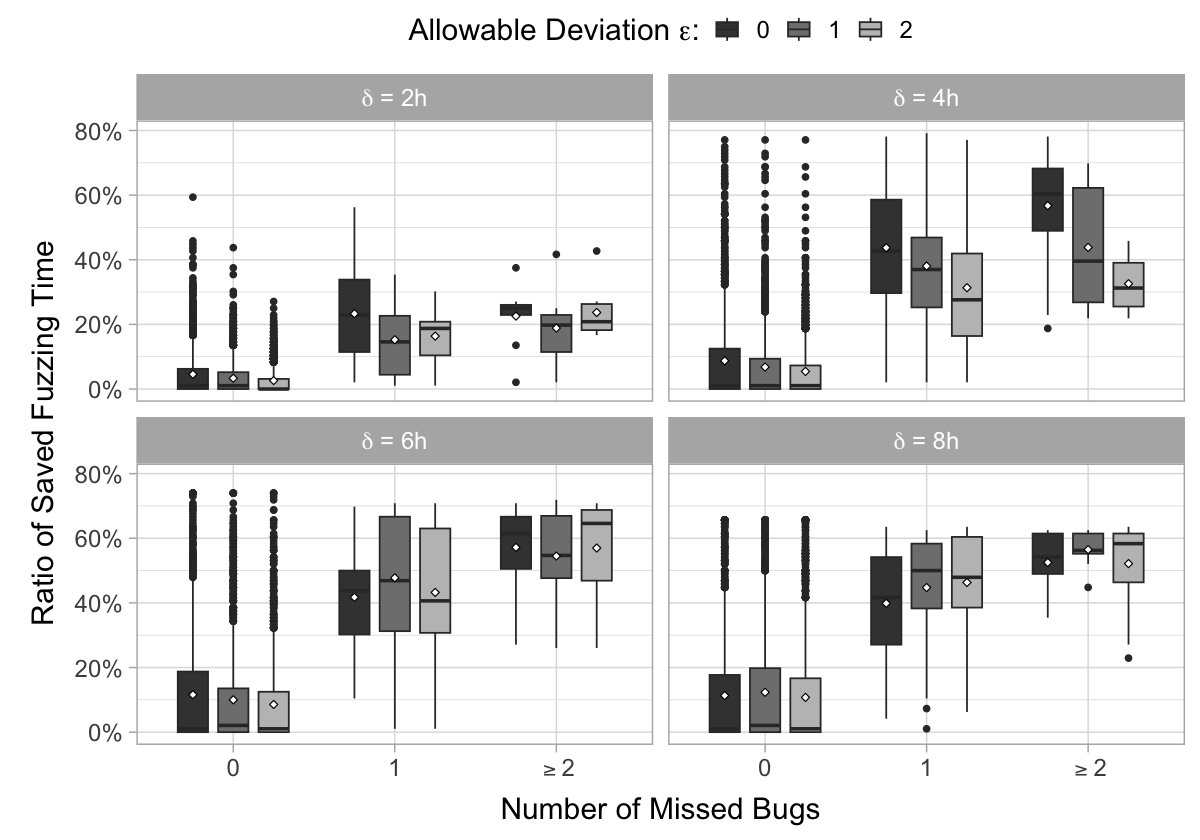

In [53]:
options(repr.plot.width = 10, repr.plot.height = 7)

tradeoff_data |>
    filter(Sat_Length %in% (60 * seq(2, 8, 2))) |>
    mutate(Sat_Length = Sat_Length / 60) |>
    mutate(N_Diff_Bug_Range2 = ifelse(N_Diff_Bugs2 >= 2, "[2, Inf)", as.character(N_Diff_Bugs2))) |>
    mutate(N_Diff_Bug_Range2 = factor(N_Diff_Bug_Range2, levels = c("0", "1", "[2, Inf)"))) |>
    ggplot(aes(x = N_Diff_Bug_Range2, y = Ratio_Diff_Timeout2, fill = as.factor(Delta), alpha = as.factor(Delta))) +
        labs(x = "Number of Missed Bugs", y = "Ratio of Saved Fuzzing Time", fill = expression(paste("Allowable Deviation ", epsilon, ":", sep = ""))) +
        geom_boxplot(position = position_dodge2(padding = 0.25, preserve = "single")) +
        stat_summary(fun = mean, geom = "point", shape = 23, fill = "white", position = position_dodge2(width = .75, preserve = "single")) +
        facet_wrap(. ~ Sat_Length, labeller = labeller(Sat_Length = as_labeller(sat_length_exprs_str, label_parsed))) +
        scale_x_discrete(labels = c("0", "1", expression("" >= 2))) +
        scale_y_continuous(labels = scales::percent) +
        scale_fill_manual(values = gray_color_tones) +
        scale_alpha_manual(values = c(1, 1, 1)) +
        theme(legend.position = "top") +
        guides(alpha = "none")

ggsave(figure_path("fig5-2d"), width = 10, height = 7)